In [201]:
import os
import math
import pandas as pd
import concurrent.futures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from glob import glob
import pybedtools
import re
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
from scipy import stats
from statsmodels.stats.multitest import multipletests,fdrcorrection

In [202]:
os.chdir("/media/ssd/rita/project/104e/figures/TE_analysis/")

In [203]:
BASE = "/media/ssd/rita/project/104e/repeat_annotations/REPET_v3.9"
WORKDIR = "/media/ssd/rita/project/104e/figures/TE_analysis"
TE_post_analysis_file = f"{BASE}/full_chr_allTEs_nr_noSSR_join_path.annotStatsPerTE.tab"
classif_file = f"{BASE}/full_refTEs.classif"
gff_TE_file = f"{WORKDIR}/full_TEs.gff3"
centromere_file = f"{WORKDIR}/Pst104E_centromeres_refined.xlsx"
assembly_fai_file = f"{WORKDIR}/v3.9.chr.haplotype-paired.fasta.fai"
chr_natural_order = [f"chr{n}{hap}" for n in range(1, 19) for hap in ["A", "B"]]
TE_order_dict = {"Class I": ["LTR", "DIRS", "LINE", "SINE", "LARD", "TRIM", "Unclassified Class I"], \
                 "Class II": ["TIR", "Helitron", "Maverick", "MITE", "Unclassified Class II"], \
                 "Unclassified": ["Unclassified Class"],
                 "All": ["LTR", "DIRS", "LINE", "SINE", "LARD", "TRIM", "Unclassified Class I",\
                                                          "TIR", "Helitron", "Maverick", "MITE", "Unclassified Class II",\
                                                          "Unclassified Class"]}

### process consensus TE library classification file

read in the REPET classfication file which contains the PASTEC code and RepBase (v27.06) blast results per consensus TE.

In [204]:
classif_df = pd.read_csv(classif_file, sep="\t", header=None, usecols=(0,1,2,3,4,5,6,8,9)).replace(pd.NA, "NaN")
classif_df.columns = ["TE", "length", "strand", "confuse", "class", "order", "code", "confidence_index", "coding_feature"]
# get value counts of pastec code
print(f'refTEs no: {classif_df["code"].value_counts().sum()}')
#classif_df = classif_df[classif_df["confuse"] == False]
classif_df["code"].value_counts()

refTEs no: 2942


code
NaN                  1172
DTX                   638
RLX                   502
DXX                   210
DXX-MITE              145
PHG                    56
DHX                    39
DTX|RLX                34
RXX-TRIM               20
RLX|RYX                15
DXX|RLX                11
RIX                    11
RYX                    11
DXX-MITE|RLX            9
RXX-LARD                8
DMX|DTX                 8
DHX|DTX                 7
DTX|DMX                 5
RLX|RYX|DTX             4
RSX                     4
RYX|RLX                 4
RLX|RIX                 3
DTX|RIX                 3
RIX|DTX                 3
RXX                     3
RLX|DTX                 2
DHX|RLX                 2
DTX|RLX|RYX             1
RLX|DTX|DMX             1
DTX|RXX-LARD            1
RLX|DTX|RYX             1
RIX|RLX                 1
RXX-TRIM|DHX            1
RLX|DXX                 1
RLX|DTX|DMX|RYX         1
DTX|RXX                 1
RXX-TRIM|DXX-MITE       1
RSX|RIX                 1
DMX    

#### superfamily classification
PASTEC classifies TEs based on wicker's classification. 
use tblastx and blastx results take the best match


In [205]:
class_dict = {"R":"ClassI", "D":"DNA ClassII"}
orderI_dict = {"L":"LTR", "Y":"DIRS", "P":"Penelope", "I":"LINE", "S":"SINE", "X":"?"}
orderII_dict = {"T":"TIR", "Y":"Crypton", "H": "Helitron", "M":"Maverick", "X":"?"}
superfamII_dict = {"C":"Copia", "G":"Ty3"}

In [206]:
def convert_pastec_to_COS(pastec_code):
    """
    converts pastec code to class:order:superfamily.
    """
    if pastec_code == "NaN":
        return "noCat"
    elif pastec_code == "PHG":
        return "PHG" # to be filtered out later.
    
    if "MITE" in pastec_code:
        return "ClassII:MITE:?"
    if "LARD" in pastec_code:
        return "ClassI:LARD:?"
    if "TRIM" in pastec_code:
        return "ClassI:TRIM:?"

    val = ""
    if pastec_code[0] == "D":
        val += "ClassII:"
    if pastec_code[0] == "R":
        val += "ClassI:"
    if pastec_code[0] != "D" and pastec_code[0] != "R":
        val = "noCat"
        
    if pastec_code[1:] == "XX":
        val += "?:?"
    if pastec_code[1] == "T":
        val += "TIR:?"
    if pastec_code[1] == "H":
        val += "Helitron:?"
    if pastec_code[1] == "M":
        val += "Maverick:?"
    if pastec_code[0:2] == "DY":
        val += "Crypton:?"
    if pastec_code[1] == "I":
        val += "LINE:?"
    if pastec_code[1] == "L":
        val += "LTR:?"
    if pastec_code[1] == "P":
        val += "Penelope:?"
    if pastec_code[1] == "S":
        val += "SINE:?"
    if pastec_code[0:2] == "RY":
        val += "DIRS:?"
    return val


def parse_blast_hit_or_reclassify(row, level="order"):
    """
    parse blast hit from the coding feature column.
    if level is specified as order, simply take the pastec column and convert to full code string with function convert_pastec_to_COS.
    if level is specified as superfamily, it will parse blast results and determine the most frequent type hit.
    also tries to reclassify confused rows based on blast hit with the highest perc_identity.
    """
    coding_feat = [row["coding_feature"]]
    if row["confuse"] == False:
        blast_hit_pattern = re.compile(r'(TE_BLR\w*:.*?%[);])') # this greps the name of hit only.
        for n in coding_feat:
            if level == "order":
                return convert_pastec_to_COS(row["code"])
            elif level == "superfamily":
                # init C:O based on PASTEC code
                pastec_translate = ":".join(convert_pastec_to_COS(row["code"]).split(":")[:2])
                # now determine the superfamily based on most frequent blast hit
                # first extract all the c:o:s from blast results
                cos_pattern = re.compile(r'Class\w*(?::\w*)*')
                TE_match = "".join(blast_hit_pattern.findall(n))
                TE_match = cos_pattern.findall(TE_match)
                if len(TE_match) > 0:
                    # if full cos, find the most frequent.
                    # if not full cos, translate from pastec to have a full code.
                    # then find the most frequent one.
                    results = []
                    for match in TE_match:
                        cos_fields = match.rstrip(":").split(":")
                        if len(cos_fields) == 3:
                            cos = ":".join(cos_fields)
                        else:
                            cos = convert_pastec_to_COS(row["code"])
                        results.append(cos)
                    # now find the most frequent cos.
                    result = max(set(results),key=results.count)
                    return result
                # if TE match is empty e.g. coding=(NA), just translate pastec
                else:
                    return convert_pastec_to_COS(row["code"])
                
    # reclassify confused TEs using blast hit with the best match
    if row["confuse"] == True:
        blast_hit_pattern = re.compile(r"TE_BLR\w*: (\S*)\s*([0-9.]+%)") # this grep the name of hit and the perc identity.
        for n in coding_feat:
            TE_match = blast_hit_pattern.findall(n)
            if level == "order":
                return convert_pastec_to_COS(row["code"])
            elif level == "superfamily":
                # do not use pastec since its uncertain
                if len(TE_match) > 0:
                    highest_percent = 0
                    highest_percent_name = ""
                    for name, percent in TE_match:
                        name = ":".join(name[:-1].split(":")[1:])
                        percent = float(percent.rstrip("%"))
                        if percent > highest_percent:
                            highest_percent = percent
                            highest_percent_name = name
                    if highest_percent <= 70:
                        return "noCat"
                    else:
                        name_fields = highest_percent_name.split(":")
                        if len(name_fields) > 3:
                            return ":".join(name_fields[:3])
                        else:
                            return name
                else:
                    return "noCat"

In [207]:
#parse blast hit to class:order:superfamily and reclassify confused TEs if able.
parsed_blast_hit = []
for idx, row in classif_df.iterrows():
    parsed_blast_hit.append(parse_blast_hit_or_reclassify(row, level="superfamily"))
# add COS column to classif_df
classif_df["COS"] = parsed_blast_hit
# remove potential host genes
classif_df = classif_df[classif_df["COS"] != "PHG"]

### append COS code to consensus TEs stats

consensus TE stats are stored in post TEannot tab. 

parse it to df, add class:order:superfamily column and insertion time estimation.

In [208]:
TE_post_analysis_df_header = "TE      length  covg    frags   fullLgthFrags   copies  fullLgthCopies  meanId  sdId    minId   q25Id   medId   q75Id   maxId   meanLgth        sdLgth  minLgth q25Lgth medLgth q75Lgth     maxLgth meanLgthPerc    sdLgthPerc      minLgthPerc     q25LgthPerc     medLgthPerc     q75LgthPerc     maxLgthPerc".split()
TE_post_analysis_df = pd.read_csv(TE_post_analysis_file, sep="\t", header=None)
TE_post_analysis_df.columns = TE_post_analysis_df_header
# add class:order:superfam column
TE_post_analysis_df = pd.merge(TE_post_analysis_df, classif_df[["TE", "COS"]], on="TE")
TE_post_analysis_df.iloc[:,1:28] = TE_post_analysis_df.iloc[:,1:28].astype(float)
# add TE age
TE_post_analysis_df["TE_age"] = ((100-TE_post_analysis_df["meanId"])/100)/(2*(10**-9))
TE_post_analysis_df["TE_age_Mya"] = (((100-TE_post_analysis_df["meanId"])/100)/(2*(10**-9)))/1000000
TE_post_analysis_df = TE_post_analysis_df[TE_post_analysis_df["copies"]>=2]

In [209]:
TE_post_analysis_df["COS"].value_counts()

COS
noCat                        1255
ClassI:LTR:Gypsy              405
ClassII:?:?                   214
ClassII:TIR:?                 194
ClassII:TIR:hAT               176
ClassII:MITE:?                145
ClassI:LTR:Copia              111
ClassII:TIR:PIF                93
ClassII:TIR:Tc1                89
ClassII:TIR:MuDR               74
ClassII:Helitron:?             25
ClassI:TRIM:?                  20
ClassII:Helitron:Helitron      14
ClassI:LINE:?                  11
ClassII:TIR:P                  11
ClassI:DIRS:DIRS               10
ClassI:LARD:?                   8
ClassII:?:Academ                7
ClassI:LTR:?                    6
ClassII:TIR:CACTA               5
ClassI:SINE:?                   4
ClassI:?:?                      3
ClassII:TIR:Tc1-Mariner         2
ClassII:TIR:PIF-Harbinger       1
ClassII:Maverick:?              1
Name: count, dtype: int64

In [210]:
TE_post_analysis_df

,TE,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,...,meanLgthPerc,sdLgthPerc,minLgthPerc,q25LgthPerc,medLgthPerc,q75LgthPerc,maxLgthPerc,COS,TE_age,TE_age_Mya
0,hapA-B-G1016-Map6_reversed,1571.0,25406.0,56.0,11.0,53.0,12.0,85.84,8.44,71.3,...,31.44,37.83,2.29,9.48,12.67,25.97,101.4,noCat,70800000.0,70.8
1,hapA-B-G1023-Map3,1598.0,30086.0,68.0,7.0,62.0,8.0,80.87,8.27,64.1,...,30.47,31.74,1.5,11.33,18.18,27.66,102.94,ClassII:TIR:?,95650000.0,95.65
2,hapA-B-G1024-Map3,1597.0,19086.0,58.0,4.0,53.0,5.0,80.94,9.5,65.3,...,23.35,29.23,1.31,7.51,16.59,18.6,105.39,ClassI:LTR:Copia,95300000.0,95.3
3,hapA-B-G1025-Map10_reversed,1980.0,2338.0,8.0,1.0,7.0,1.0,87.43,7.28,72.7,...,17.12,34.58,1.11,2.42,3.74,10.35,95.25,ClassII:TIR:Tc1,62850000.0,62.85
4,hapA-B-G1026-Map3,1629.0,10873.0,36.0,3.0,33.0,3.0,84.68,8.0,72.2,...,20.28,28.81,2.39,4.11,9.45,19.89,100.12,noCat,76600000.0,76.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,hapB-B-R99-Map3,829.0,17290.0,100.0,2.0,86.0,2.0,84.63,6.6,68.5,...,24.48,26.57,3.14,7.12,12.67,35.22,100.0,ClassII:MITE:?,76850000.0,76.85
2882,hapB-B-R991-Map4,1518.0,22144.0,58.0,6.0,52.0,6.0,78.72,9.63,63.0,...,28.06,32.27,2.17,6.92,12.78,37.15,103.23,noCat,106400000.0,106.4
2883,hapB-B-R995-Map3,610.0,5800.0,16.0,6.0,13.0,7.0,87.26,5.92,79.55,...,73.14,40.27,11.97,27.54,99.84,100.82,105.74,ClassI:LTR:Gypsy,63700000.0,63.7
2884,hapB-B-R996-Map3,683.0,1366.0,2.0,2.0,2.0,2.0,97.05,4.17,94.1,...,100.0,0.0,100.0,100.0,100.0,100.0,100.0,noCat,14750000.0,14.75


### Summarise refTE statistics by order

In [211]:
# split the COS code
TE_post_analysis_df[["Class", "Order", "Superfamily"]] = [n.split(":") if n.startswith("Class") else ["noCat", "noCat", "noCat"] for n in TE_post_analysis_df["COS"]]

# since we're going to stack bars for LTR/LTR-Ty3, create another column where everything will be the same as Order
# except for LTR/LTR-Ty3 to differentiate them.
# then fix some names up for better readability.
for idx, row in TE_post_analysis_df.iterrows():
    if row["Order"] == "?":
        TE_post_analysis_df.loc[idx, "Order"] = f'Unclassified Class {row["Class"].split("Class")[-1]}'
    if row["Order"] == "noCat":
        TE_post_analysis_df.loc[idx, "Order"] = "Unclassified Class"
    if row["Superfamily"] == "Gypsy":
        TE_post_analysis_df.loc[idx, "Order"] = "LTR-Ty3"

In [356]:
def TE_post_analysis_df_sum_by_level(df,genome_size,level="Order"):
    if level == "Order":
        TE_post_analysis_df_sum = df.groupby("Order").sum()[["covg", "copies"]]
        TE_post_analysis_df_sum["coverage_perc"] = (TE_post_analysis_df_sum["covg"] / genome_size) * 100
        # set another column for grouping LTR and LTR_Ty3 as LTR
        TE_post_analysis_df_sum["Order_v2"] = TE_post_analysis_df_sum.index
        TE_post_analysis_df_sum.loc["LTR-Ty3", "Order_v2"] = "LTR"
        # copy coverage percentage for "LTR" from "LTR-Ty3"
        TE_post_analysis_df_sum["coverage_perc_v2"] = 0
        TE_post_analysis_df_sum.loc["LTR", "coverage_perc_v2"] = TE_post_analysis_df_sum.loc["LTR-Ty3", "coverage_perc"]
        TE_post_analysis_df_sum.drop("LTR-Ty3", inplace=True)
        TE_post_analysis_df_sum = TE_post_analysis_df_sum.reindex(TE_order_dict["All"])
    elif level == "COS":
        TE_post_analysis_df_sum = df.groupby("COS").sum()[["covg", "copies"]]
        # convert coverage to % coverage.
        TE_post_analysis_df_sum["coverage_perc"] = (TE_post_analysis_df_sum["covg"]/genome_size)*100
    return TE_post_analysis_df_sum

def plot_TE_coverage_by_order(df):
    sns.set(style="ticks")
    colors = sns.color_palette('RdBu', n_colors=len(df.index.unique()))
    colors[-1] = "#636363"
    
    plt.figure(figsize=(6, 3))
    ax = plt.bar(df.index, df["coverage_perc"], linestyle='-', color=colors, label="coverage_perc", edgecolor="black")
    ax = plt.bar(df.index, df["coverage_perc_v2"], linestyle='-', color="#E57373", bottom=df["coverage_perc"], label="coverage_perc_v2", edgecolor="black")

    plt.xlabel("")
    plt.ylabel("% coverage")
    plt.xticks(rotation=90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(True, axis='y', linestyle='--')
    plt.suptitle("Fraction of Pst104E genome covered by different TE orders", fontsize=11)
    ax = plt.gca()
    ax.yaxis.set_major_locator(MultipleLocator(2))
    plt.show()
    
def plot_TE_coverage_by_superfam(TE_post_analysis_df_superfam_sum, figsize=(6, 6), title="", xlabel="% genome coverage", ylabel="", colors=None, num_ticks=None):
    tmp = TE_post_analysis_df_superfam_sum.copy().reset_index()
    tmp["class"] = tmp["COS"].apply(lambda x: x.split(":")[0])
    tmp = tmp.groupby("class")[["covg", "copies", "coverage_perc"]].sum()
    tmp = tmp.iloc[0:2, :]
    tmp = tmp.reset_index()
    tmp["class"] = tmp["class"] + " total"
    tmp = tmp.set_index("class")
    
    class_i_row = tmp.loc["ClassI total"]
    TE_post_analysis_df_superfam_sum = pd.concat([class_i_row.to_frame().T, TE_post_analysis_df_superfam_sum])
    
    class_ii_row = tmp.loc["ClassII total"]
    before_10_row = TE_post_analysis_df_superfam_sum.iloc[:10]
    after_10_row = TE_post_analysis_df_superfam_sum.iloc[10:]
    TE_post_analysis_df_superfam_sum = pd.concat([before_10_row, class_ii_row.to_frame().T, after_10_row])
    
    plt.figure(figsize=figsize)
    sns.set(style="ticks")
    colors = sns.color_palette('Reds', n_colors=10)[::-1] +sns.color_palette('Blues', n_colors=16)[::-1] + ["#636363"]
    print(colors)
    ax = plt.gca()
    ax.barh(TE_post_analysis_df_superfam_sum.index, TE_post_analysis_df_superfam_sum["coverage_perc"], linestyle='-', color=colors, label="coverage_perc", edgecolor="black")
    # Customize the plot
    labels = ax.get_yticklabels()
    for lbl in labels:
        if 'total' in lbl.get_text():
            lbl.set_fontweight('bold')
    plt.xlabel(xlabel, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.grid(True, axis='x', linestyle='--')
    plt.suptitle(title, fontsize=11)
    plt.yticks(fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlim(0,20)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    plt.show()
    return TE_post_analysis_df_superfam_sum

In [327]:
dikaryotic_TE_post_analysis_df_sum = TE_post_analysis_df_sum_by_order(TE_post_analysis_df, 152328638)
dikaryotic_TE_post_analysis_df_sum

/tmp/ipykernel_383573/1845798211.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11.207234059297503' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  TE_post_analysis_df_sum.loc["LTR", "coverage_perc_v2"] = TE_post_analysis_df_sum.loc["LTR-Ty3", "coverage_perc"]


,covg,copies,coverage_perc,Order_v2,coverage_perc_v2
Order,,,,,
LTR,4289914.0,5208.0,2.816223,LTR,11.207234
DIRS,401154.0,472.0,0.263348,DIRS,0.000000
LINE,357070.0,351.0,0.234408,LINE,0.000000
SINE,75662.0,98.0,0.04967,SINE,0.000000
LARD,266932.0,631.0,0.175234,LARD,0.000000
TRIM,333536.0,1465.0,0.218958,TRIM,0.000000
Unclassified Class I,59386.0,96.0,0.038985,Unclassified Class I,0.000000
TIR,18624002.0,35185.0,12.226199,TIR,0.000000
Helitron,1303205.0,1999.0,0.855522,Helitron,0.000000


In [214]:
TE_post_analysis_df["haplotype"] = TE_post_analysis_df["TE"].apply(lambda x: x[:4])
hapA_genome_size = 77128783
hapB_genome_size = 75199855
dikaryotic_genome_size =152328638
hapA_TE_post_analysis_df_sum = TE_post_analysis_df_sum_by_order(TE_post_analysis_df[TE_post_analysis_df["haplotype"]=="hapA"], hapA_genome_size)
hapB_TE_post_analysis_df_sum = TE_post_analysis_df_sum_by_order(TE_post_analysis_df[TE_post_analysis_df["haplotype"]=="hapB"], hapB_genome_size)

/tmp/ipykernel_383573/1845798211.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '11.54197778538785' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  TE_post_analysis_df_sum.loc["LTR", "coverage_perc_v2"] = TE_post_analysis_df_sum.loc["LTR-Ty3", "coverage_perc"]
/tmp/ipykernel_383573/1845798211.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.863903926410497' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  TE_post_analysis_df_sum.loc["LTR", "coverage_perc_v2"] = TE_post_analysis_df_sum.loc["LTR-Ty3", "coverage_perc"]


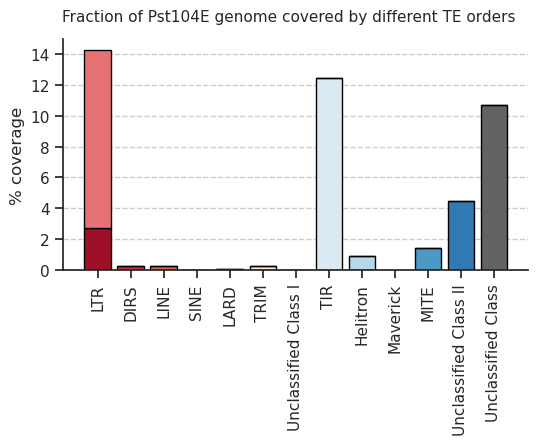

In [129]:
# hapA
plot_TE_coverage_by_order(hapA_TE_post_analysis_df_sum)

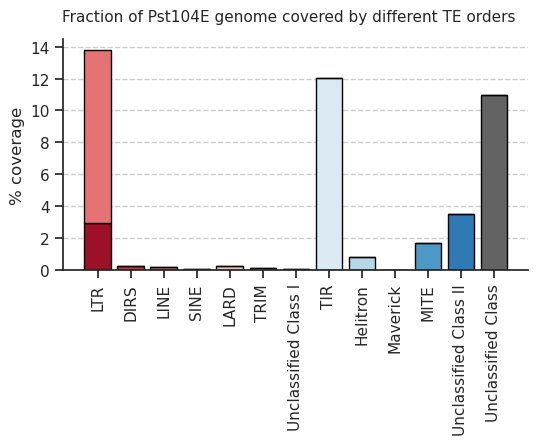

In [130]:
#hapB
plot_TE_coverage_by_order(hapB_TE_post_analysis_df_sum)

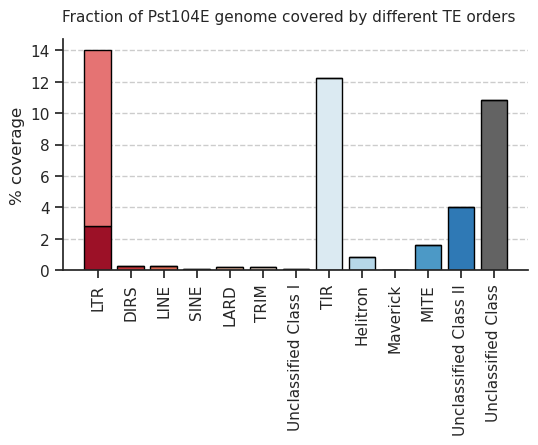

In [132]:
plot_TE_coverage_by_order(dikaryotic_TE_post_analysis_df_sum)

In [316]:
hapA_TE_post_analysis_df_superfam_sum = TE_post_analysis_df_sum_by_level(TE_post_analysis_df[TE_post_analysis_df["haplotype"]=="hapA"], hapA_genome_size, level="COS")
hapB_TE_post_analysis_df_superfam_sum = TE_post_analysis_df_sum_by_level(TE_post_analysis_df[TE_post_analysis_df["haplotype"]=="hapB"], hapB_genome_size, level="COS")
dikaryotic_TE_post_analysis_df_superfam_sum = TE_post_analysis_df_sum_by_level(TE_post_analysis_df, dikaryotic_genome_size, level="COS")

In [338]:
dikaryotic_TE_post_analysis_df_superfam_sum

,covg,copies,coverage_perc
COS,,,
ClassI:?:?,59386.0,96.0,0.038985
ClassI:DIRS:DIRS,401154.0,472.0,0.263348
ClassI:LARD:?,266932.0,631.0,0.175234
ClassI:LINE:?,357070.0,351.0,0.234408
ClassI:LTR:?,153251.0,750.0,0.100606
ClassI:LTR:Copia,4136663.0,4458.0,2.715617
ClassI:LTR:Gypsy,17071827.0,20129.0,11.207234
ClassI:SINE:?,75662.0,98.0,0.04967
ClassI:TRIM:?,333536.0,1465.0,0.218958


[(0.579361783929258, 0.04244521337946944, 0.07361783929257976), (0.7130949634755863, 0.0744636678200692, 0.0962552864282968), (0.8193310265282583, 0.11672433679354094, 0.12341407151095732), (0.9256286043829296, 0.22006920415224915, 0.1677047289504037), (0.9673356401384082, 0.34918877354863515, 0.24775086505190314), (0.9857285659361784, 0.4722798923490965, 0.34678969627066514), (0.9882352941176471, 0.5857900807381776, 0.46223760092272204), (0.9882352941176471, 0.7068512110726644, 0.6010149942329873), (0.9926028450595925, 0.8141330257593233, 0.7383775470972702), (0.9971703191080353, 0.901361014994233, 0.8562860438292964), (0.03137254901960784, 0.2491349480968858, 0.5100346020761246), (0.03137254901960784, 0.31003460207612454, 0.6004613610149943), (0.07174163783160323, 0.3693194925028835, 0.6521337946943484), (0.11787773933102653, 0.4283737024221453, 0.6982698961937717), (0.17508650519031155, 0.4888119953863899, 0.7333333333333334), (0.23598615916955018, 0.5497116493656286, 0.764705882352

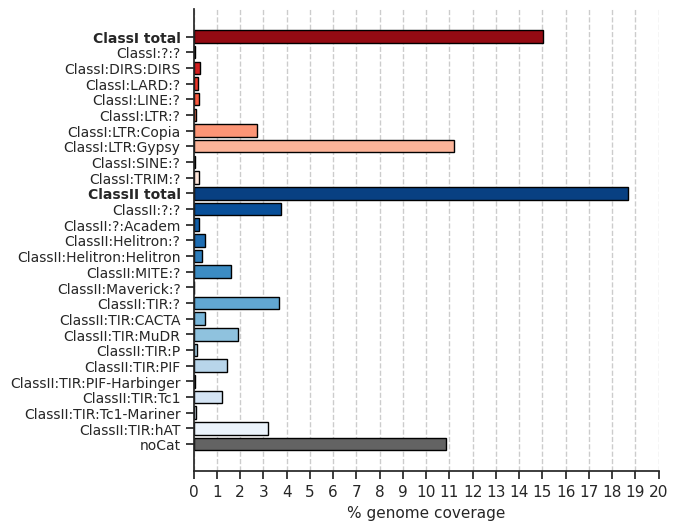

,covg,copies,coverage_perc
ClassI total,22855481.0,28450.0,15.00406
ClassI:?:?,59386.0,96.0,0.038985
ClassI:DIRS:DIRS,401154.0,472.0,0.263348
ClassI:LARD:?,266932.0,631.0,0.175234
ClassI:LINE:?,357070.0,351.0,0.234408
ClassI:LTR:?,153251.0,750.0,0.100606
ClassI:LTR:Copia,4136663.0,4458.0,2.715617
ClassI:LTR:Gypsy,17071827.0,20129.0,11.207234
ClassI:SINE:?,75662.0,98.0,0.04967
ClassI:TRIM:?,333536.0,1465.0,0.218958


In [357]:
plot_TE_coverage_by_superfam(dikaryotic_TE_post_analysis_df_superfam_sum)

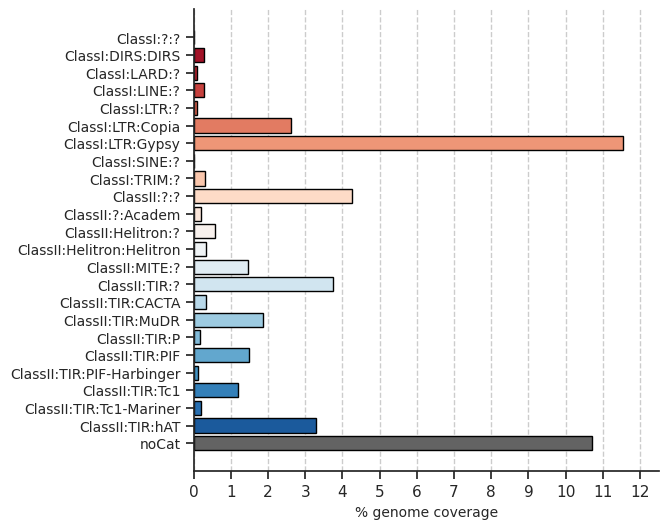

In [120]:
plot_TE_coverage_by_superfam(hapA_TE_post_analysis_df_superfam_sum)

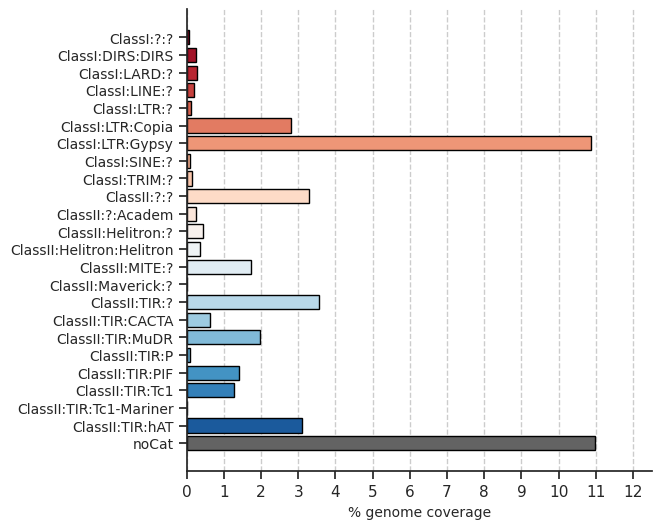

In [121]:
plot_TE_coverage_by_superfam(hapB_TE_post_analysis_df_superfam_sum)

In [15]:
TE_post_analysis_df_superfam_sum

,covg,copies,coverage_perc
COS,,,
ClassI:?:?,59386.0,96.0,0.038985
ClassI:DIRS:DIRS,401154.0,472.0,0.263348
ClassI:LARD:?,266932.0,631.0,0.175234
ClassI:LINE:?,357070.0,351.0,0.234408
ClassI:LTR:?,153251.0,750.0,0.100606
ClassI:LTR:Copia,4136663.0,4458.0,2.715617
ClassI:LTR:Gypsy,17071827.0,20129.0,11.207234
ClassI:SINE:?,75662.0,98.0,0.04967
ClassI:TRIM:?,333536.0,1465.0,0.218958


In [151]:
TE_post_analysis_df[TE_post_analysis_df["meanId"] == TE_post_analysis_df["meanId"].min()]

,TE,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,...,medLgthPerc,q75LgthPerc,maxLgthPerc,COS,TE_age,TE_age_Mya,Class,Order,Superfamily,haplotype
2820,hapB-B-R699-Map3,2361.0,57876.0,111.0,2.0,93.0,2.0,67.43,6.25,58.8,...,16.9,39.86,107.33,noCat,162850000.0,162.85,noCat,Unclassified Class,noCat,hapB


In [218]:
def sort_dataframe_by_desired_order(df, desired_order_list):
    subset_df = df[df["COS"].str.startswith(desired_order_list[0].split(":")[0])]
    subset_df["COS"] = pd.Categorical(subset_df["COS"], categories=desired_order_list, ordered=True)
    sorted_df = subset_df.sort_values(by="COS").reset_index(drop=True)
    return sorted_df

classI_sorted_names = TE_post_analysis_df_superfam_sum[TE_post_analysis_df_superfam_sum.index.str.startswith("ClassI:")].index.tolist()
classI_df_sorted = sort_dataframe_by_desired_order(TE_post_analysis_df, classI_sorted_names)

classII_sorted_names = TE_post_analysis_df_superfam_sum[TE_post_analysis_df_superfam_sum.index.str.startswith("ClassII:")].index.tolist()
classII_df_sorted = sort_dataframe_by_desired_order(TE_post_analysis_df, classII_sorted_names)

nocat_df = TE_post_analysis_df[TE_post_analysis_df["COS"].str.startswith("noCat")]  


/tmp/ipykernel_383573/3425911693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["COS"] = pd.Categorical(subset_df["COS"], categories=desired_order_list, ordered=True)
/tmp/ipykernel_383573/3425911693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df["COS"] = pd.Categorical(subset_df["COS"], categories=desired_order_list, ordered=True)


/tmp/ipykernel_383573/3519719090.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=classI_df, x="TE_age", y="COS", palette="Reds_r", ax=ax[0], linecolor="black")
/tmp/ipykernel_383573/3519719090.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=classII_df, x="TE_age", y="COS", palette="Blues_r", ax=ax[1], linecolor="black")


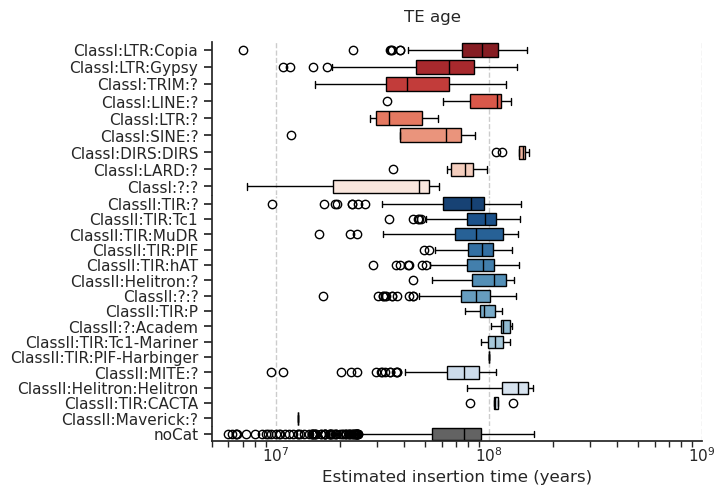

In [219]:
sns.set(style="ticks")
fig, ax = plt.subplots(3, 1, figsize=(7,4.5), gridspec_kw={'height_ratios': [2, 3, 0.18]}, sharex=True)
classI_df = TE_post_analysis_df[TE_post_analysis_df["COS"].str.startswith("ClassI:")]
classII_df = TE_post_analysis_df[TE_post_analysis_df["COS"].str.startswith("ClassII:")]    
ax[0].set_xscale("log")
ax[0].set_xlim(5 * 10 ** 6, 10 ** 9)
ax[0].set_xticks([])  # Remove x-axis ticks
sns.boxplot(data=classI_df, x="TE_age", y="COS", palette="Reds_r", ax=ax[0], linecolor="black")
ax[0].set_ylabel("")
ax[0].set_xlabel("", fontsize=12)  # Set empty string for x-label
ax[0].xaxis.grid(True, linestyle='--')
ax[0].tick_params(axis='x', which='both', bottom=False, top=False)  # Remove x tick marks
sns.despine(ax=ax[0], trim=False, left=False, bottom=True)

ax[1].set_xscale("log")
ax[1].tick_params(axis='x', which='both',length=0)  # Remove only x ticks
ax[1].set_xlim(5 * 10 ** 6, 10 ** 9)
sns.boxplot(data=classII_df, x="TE_age", y="COS", palette="Blues_r", ax=ax[1], linecolor="black")
ax[1].set_ylabel("")
ax[1].set_xlabel("", fontsize=12)  # Set empty string for x-label
ax[1].xaxis.grid(True, linestyle='--')
sns.despine(ax=ax[1], trim=False, left=False, bottom=True)


ax[2].set_xscale("log")
ax[2].tick_params(axis='x', length=0) 
ax[2].set_xlim(5 * 10 ** 6, 10 ** 9)
sns.boxplot(data=nocat_df, x="TE_age", y="COS", color="#636363", ax=ax[2], linecolor="black")
ax[2].xaxis.grid(True, linestyle='--')
ax[2].set_xlabel("Estimated insertion time (years)", fontsize=12)
ax[2].set_ylabel("", fontsize=12)
sns.despine(ax=ax[2], trim=False, left=False, bottom=False)


plt.suptitle("TE age", fontsize=12, x=0.6, y=1.05)
plt.tight_layout(pad=-0.17)
plt.show()

/tmp/ipykernel_383573/343142958.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=classI_df2, x="TE_age", y="Order", palette="Reds", ax=ax[0], linecolor="black")
/tmp/ipykernel_383573/343142958.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=classII_df2, x="TE_age", y="Order", palette="Blues", ax=ax[1], linecolor="black")


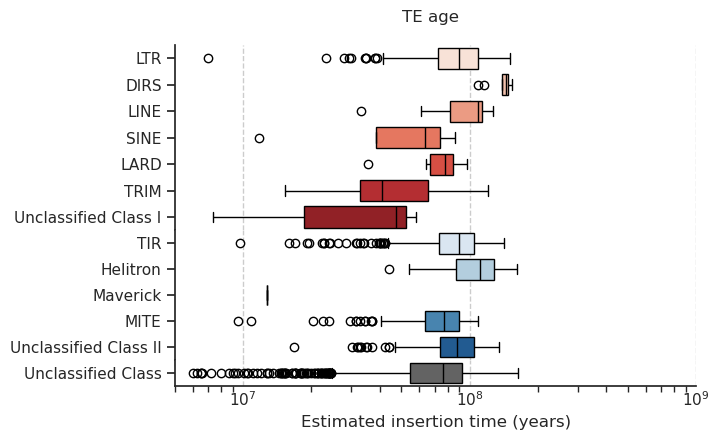

In [141]:
classI_df = TE_post_analysis_df[TE_post_analysis_df["COS"].str.startswith("ClassI:")]
classII_df = TE_post_analysis_df[TE_post_analysis_df["COS"].str.startswith("ClassII:")]    
nocat_df = TE_post_analysis_df[TE_post_analysis_df["COS"].str.startswith("noCat")]   

sns.set(style="ticks")

fig, ax = plt.subplots(3, 1, figsize=(7,4), gridspec_kw={'height_ratios': [2, 1.4, 0.28]}, sharex=True)
ax[0].set_xscale("log")
classI_df2 = classI_df.copy()
classI_df2.sort_values(by="Order", inplace=True)
classI_df2["Order"] = pd.Categorical(classI_df2["Order"], categories=TE_order_dict["Class I"], ordered=True)
ax[0].set_xlim(5 * 10 ** 6, 10 ** 9)
ax[0].set_xticks([])  # Remove x-axis ticks
sns.boxplot(data=classI_df2, x="TE_age", y="Order", palette="Reds", ax=ax[0], linecolor="black")
ax[0].set_ylabel("")
ax[0].set_xlabel("", fontsize=12)  # Set empty string for x-label
ax[0].xaxis.grid(True, linestyle='--')
ax[0].tick_params(axis='x', which='both', bottom=False, top=False)  # Remove x tick marks
sns.despine(ax=ax[0], trim=False, left=False, bottom=True)

ax[1].set_xscale("log")
ax[1].tick_params(axis='x', length=0)  # Remove only x ticks
classII_df2 = classII_df.copy()
classII_df2.sort_values(by="Order", inplace=True)
classII_df2["Order"] = pd.Categorical(classII_df2["Order"], categories=TE_order_dict["Class II"], ordered=True)
ax[1].set_xlim(5 * 10 ** 6, 10 ** 9)
sns.boxplot(data=classII_df2, x="TE_age", y="Order", palette="Blues", ax=ax[1], linecolor="black")
ax[1].set_ylabel("")
ax[1].set_xlabel("", fontsize=12)  # Set empty string for x-label
ax[1].xaxis.grid(True, linestyle='--')
sns.despine(ax=ax[1], trim=False, left=False, bottom=True)


ax[2].set_xscale("log")
ax[2].tick_params(axis='x', length=0) 
nocat_df = nocat_df.copy()
nocat_df.sort_values(by="Order", inplace=True)
nocat_df["Order"] = pd.Categorical(nocat_df["Order"], categories=TE_order_dict["Unclassified"], ordered=True)
ax[2].set_xlim(5 * 10 ** 6, 10 ** 9)
sns.boxplot(data=nocat_df, x="TE_age", y="Order", color="#636363", ax=ax[2], linecolor="black")
ax[2].xaxis.grid(True, linestyle='--')
ax[2].set_xlabel("Estimated insertion time (years)", fontsize=12)
ax[2].set_ylabel("", fontsize=12)
sns.despine(ax=ax[2], trim=False, left=False, bottom=False)


plt.suptitle("TE age", fontsize=12, x=0.6, y=1.05)
plt.tight_layout(pad=0)
plt.show()

/tmp/ipykernel_383573/2047686501.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=classI_df2, x="TE_age_Mya", y="Order", palette="Reds", ax=ax[0])
/tmp/ipykernel_383573/2047686501.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=classII_df2, x="TE_age_Mya", y="Order", palette="Blues", ax=ax[1])


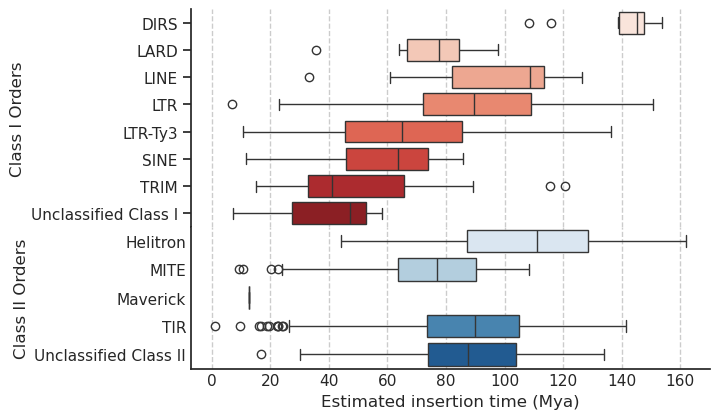

In [142]:
sns.set(style="ticks")

fig, ax = plt.subplots(2, 1, figsize=(7,4), gridspec_kw={'height_ratios': [2,1.3]}, sharex=True)
classI_df2 = classI_df.copy()
classI_df2.sort_values(by="Order", inplace=True)
ax[0].set_ylabel("Class I Orders", fontsize=12)
ax[0].set_xlabel("", fontsize=12)  # Set empty string for x-label
sns.boxplot(data=classI_df2, x="TE_age_Mya", y="Order", palette="Reds", ax=ax[0])
ax[0].xaxis.grid(True, linestyle='--')
ax[0].tick_params(axis='x', which='both', bottom=False, top=False)  # Remove tick marks only for the first subplot
sns.despine(ax=ax[0], trim=False, left=False, bottom=True)

ax[1].tick_params(axis='both', length=0)
classII_df2 = classII_df.copy()
classII_df2.sort_values(by="Order", inplace=True)
ax[1].set_ylabel("Class II Orders", fontsize=12)
ax[1].set_xlabel("Estimated insertion time (Mya)", fontsize=12)
sns.boxplot(data=classII_df2, x="TE_age_Mya", y="Order", palette="Blues", ax=ax[1])
ax[1].xaxis.grid(True, linestyle='--')
sns.despine(ax=ax[1], trim=False, left=False, bottom=False)

plt.tight_layout(pad=0)
plt.show()

/tmp/ipykernel_851587/3680723889.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=classI_df2, x="length", y="Order", palette="Reds", ax=ax[0])
/tmp/ipykernel_851587/3680723889.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=classII_df2, x="TE_age_Mya", y="Order", palette="Blues", ax=ax[1])


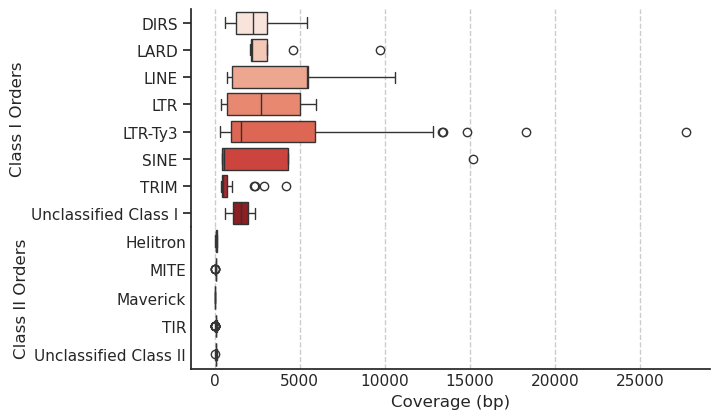

In [33]:
sns.set(style="ticks")

fig, ax = plt.subplots(2, 1, figsize=(7,4), gridspec_kw={'height_ratios': [2,1.3]}, sharex=True)
classI_df2 = classI_df.copy()
classI_df2.sort_values(by="Order", inplace=True)
ax[0].set_ylabel("Class I Orders", fontsize=12)
ax[0].set_xlabel("", fontsize=12)  # Set empty string for x-label
sns.boxplot(data=classI_df2, x="length", y="Order", palette="Reds", ax=ax[0])
ax[0].xaxis.grid(True, linestyle='--')
ax[0].tick_params(axis='x', which='both', bottom=False, top=False)  # Remove tick marks only for the first subplot
sns.despine(ax=ax[0], trim=False, left=False, bottom=True)

ax[1].tick_params(axis='both', length=0)
classII_df2 = classII_df.copy()
classII_df2.sort_values(by="Order", inplace=True)
ax[1].set_ylabel("Class II Orders", fontsize=12)
ax[1].set_xlabel("Coverage (bp)", fontsize=12)
sns.boxplot(data=classII_df2, x="TE_age_Mya", y="Order", palette="Blues", ax=ax[1])
ax[1].xaxis.grid(True, linestyle='--')
sns.despine(ax=ax[1], trim=False, left=False, bottom=False)

plt.tight_layout(pad=0)
plt.show()

In [34]:
TE_post_analysis_df["Order"].value_counts()

Order
Unclassified Class       1255
TIR                       645
LTR-Ty3                   405
Unclassified Class II     221
MITE                      145
LTR                       117
Helitron                   39
TRIM                       20
LINE                       11
DIRS                       10
LARD                        8
SINE                        4
Unclassified Class I        3
Maverick                    1
Name: count, dtype: int64

# Centromere TE enrichment


* is there a difference in overall TE coverage between centromere and non-centromere?
* which TEs are signiciantly enriched between centromere vs non-centromere?

### prepare "ground-truth" centromere and non-centromere TE bed files for observed results

In [220]:
CENTRO_ANALYSIS_BED_DIR = os.path.join(WORKDIR, "centromere_analysis_beds")
if not os.path.exists(CENTRO_ANALYSIS_BED_DIR):
    os.makedirs(CENTRO_ANALYSIS_BED_DIR)
centromere_bed = os.path.join(CENTRO_ANALYSIS_BED_DIR, "centromere_coords.bed")
TE_bed = os.path.join(CENTRO_ANALYSIS_BED_DIR, "match_TEs.bed")
assembly_fai_bed = os.path.join(CENTRO_ANALYSIS_BED_DIR, os.path.splitext(os.path.basename(assembly_fai_file))[0]+".bed")
centromere_TE_bed = os.path.join(CENTRO_ANALYSIS_BED_DIR, "centromere_TEs.bed")
noncentromere_bed = os.path.join(CENTRO_ANALYSIS_BED_DIR, "noncentromere_coords.bed")
noncentromere_TE_bed = os.path.join(CENTRO_ANALYSIS_BED_DIR, "noncentromere_TEs.bed")

In [221]:
# read centromere xlsx
centromere_df = pd.read_excel(centromere_file, engine="openpyxl", usecols=(0,1,2,3,5))
#process into centromere bed
with open(centromere_bed, "w") as file:
    for idx,row in centromere_df.iterrows():
        print("\t".join(str(row[col]) for col in ["chr", "start", "end", "centromere"]), file=file)

# convert TE gff to bed
# TE_bed = TEgff_to_TEbed(gff_TE_file)

# intersect to generate centromere TEs bed file. TE only counted in if overlapped >=50%.
# !bedtools intersect -f 0.5 -a {TE_bed} -b {centromere_bed} > {centromere_TE_bed}

# # subtract centromere from assembly fai to generate non-centromeric file
# cmd = f"awk 'OFS=\"\t\" {{print $1, 0, $2}}' {assembly_fai_file} > {assembly_fai_bed}"
# subprocess.run(cmd, shell=True)
# !bedtools subtract -a {assembly_fai_bed} -b {centromere_bed} > {noncentromere_bed}

# # intersect to generate non-centromere TEs bed file. TE only counted in if overlapped >=50%.
# !bedtools intersect -f 0.5 -a {TE_bed} -b {noncentromere_bed} > {noncentromere_TE_bed}

### Functions for generating permutations and TE enrichment analysis

In [222]:
def run_shell(command):
    subprocess.run(command, shell=True)

def TEgff_to_TEbed(gff_TE_file):
    """
    converts REPET TE gff to TE bed. 
    cleans up attribute column to keep only the matched consensus TE name.
    """
    df = pd.read_csv(gff_TE_file, header=None, sep="\t")
    df = df[df[2]=="match"]
    df[4] = df[4].astype(int)
    df[3] = df[3].astype(int)-1
    df[9] = df[8].str.extract(r'Target=([^ ;]+)') # clean up feature string to extract target
    df[[0,3,4,9,8]].to_csv(TE_bed, sep="\t", index=False, header=False) # feature kept in last column
    return TE_bed

def get_TE_bed_at_feature(TE_bed, feature_bed, outdir, min_overlap=0.5):
    """
    intersect TE bed and a feature bed (e.g. centromere) to extract TEs located in the feature.
    """
    outfn = os.path.join(outdir, f"{os.path.basename(feature_bed[:-4])}.{os.path.basename(TE_bed[:-4])}")+".bed"
    #run_shell(f"bedtools intersect -f 0.5 -a {TE_bed} -b {feature_bed} > {outfn}")
    return outfn

def permute_TE_bed(bed, assembly_fai_bed, outdir, n=10):
    """
    randomly permutes TE bed file. if bed file contains whole genome TE entries this shuffles them PER CHROMOSOME.
    """
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    outfn_list = []
    for x in range(n):
        outfn = os.path.join(outdir, os.path.basename(bed).replace(".bed", f"_random_test.{x}.bed"))
        print(outfn)
        cmd = f"bedtools shuffle -seed {x} -i {bed} -g {assembly_fai_file} -chrom > {outfn}"
        outfn_list.append(outfn)
        run_shell(cmd)
    return outfn_list

def calculate_TE_coverage_at_feature(feature_TE_bed, TE_post_analysis_df, feature_coords_bed, TEtype="Order"):
    """
    reads in a TE bed that has four columns: chr, start, end, matched consensus TE.
    query the matched consensus TE against the classif df to obtain class:order:sumperfamily code.
    then calculate TE coverage by order or COS.
    """
    # read in TE bed
    df = pd.read_csv(feature_TE_bed, sep="\t", header=None)
    df.columns = ["chr", "start", "end", "TE"]
    df[["start", "end"]] = df[["start", "end"]].astype(int)
    df["interval"] = df["end"]-df["start"]
    
    # classify TEs using the refTE classif table
    df = pd.merge(df, TE_post_analysis_df[["TE", "COS", "Class", "Order"]], on="TE")
    # check if all orders are present. if not add the order name and interval value as zero.
    if TEtype == "COS":
        all_TE_type = TE_post_analysis_df["COS"].unique()
    if TEtype == "Order":
        all_TE_type = ["DIRS", "Helitron", "LARD", "LINE", "LTR", "LTR-Ty3", "MITE", "Maverick", \
                         "SINE", "TIR", "TRIM", "Unclassified Class", "Unclassified Class I", "Unclassified Class II"]
    for chr, chr_df in df.groupby("chr"):
        missing = set(all_TE_type)-set(chr_df[TEtype])
        if len(missing) > 0:
            for TE in missing:
                new_row = pd.DataFrame({"chr":chr, "interval":[0], TEtype:[TE]})
                df = pd.concat([df,new_row],ignore_index=True)
    # get feature bed for length to compute coverage in feature region
    feature = pd.read_csv(feature_coords_bed, sep="\t", header=None, usecols=(0,1,2))
    feature.columns = ["chr", "start", "end"]
    feature["feature_len"] = feature["end"]-feature["start"]
    # if more than one region per chr take their sum, e.g. sum lengths of noncentromere regions flanking centromere.
    feature = feature.groupby("chr")["feature_len"].sum().reset_index()
    df = pd.merge(df, feature[["chr", "feature_len"]], on="chr")
    df = df.groupby(["chr", "feature_len", TEtype])["interval"].sum().reset_index()
    df.columns = ["chr", "feature_len", "TEtype", "interval"]
    df["coverage"] = (df["interval"]/df["feature_len"])*100
    return df

def calculate_TE_coverage_diff(centromere_TE_cov_df, noncentromere_TE_cov_df):
    """
    processes centromere and noncentromere TE coverage dataframes, 
    calculates TE coverage difference by (centro - noncentro).
    """
    result = pd.merge(centromere_TE_cov_df, noncentromere_TE_cov_df, \
                      on=["chr", "TEtype"], suffixes=["_centromere", "_noncentromere"])
    result = result[["chr", "TEtype", "coverage_centromere", "coverage_noncentromere"]]
    result["coverage_diff"] = result["coverage_centromere"]-result["coverage_noncentromere"]
    return result

def get_covdiff_p_value(perm_results, observed_result, chr, TEtype):
    """
    Takes in a list of df from perm_results. 
    Extracts coverage_diff values from permuted bed df, and finds proportion of values as or more extreme than observed coverage_diff at two tails.
    Returns three objects:
    - numpy array containing expected coverage_diff values from permutations
    - numpy array containing observed coverage_diff value from actual data
    - p value representing proportion of expected values as or more extreme than observed value. Unadjusted, user might need to consider multiple testing corrections afterwards.
    """
    expected_vals = np.array([df[(df["chr"]==chr)&(df["TEtype"]==TEtype)]["coverage_diff"].iloc[0] for df in perm_results])
    observed_val = observed_result[(observed_result["chr"]==chr)&(observed_result["TEtype"]==TEtype)]["coverage_diff"].iloc[0]
    # turns both into aboslute values to look at both tails.
    abs_expected_vals = np.abs(expected_vals)
    abs_observed_val = np.abs(observed_val)
    expected_vals_extreme_as_observed = abs_expected_vals[abs_expected_vals>=abs_observed_val]
    pval = len(expected_vals_extreme_as_observed)/len(expected_vals)
    #print(f"observed val: {observed_val}\npval: {pval}\n")
    return expected_vals, observed_val, pval

def get_covdiff_val_for_specific_chr_TEtype(df, chr, TEtype):
    return df[(df["chr"]==chr)&(df["TEtype"]==TEtype)]["coverage_diff"]

def extract_TE_type_covdiff_values(perm_results, chr, TEtype):
    coverage_vals = []
    for df in perm_results:
        coverage_val = get_covdiff_val_for_specific_chr_TEtype(df, chr, TEtype)
        if not coverage_val.empty:
            coverage_vals.append(coverage_val.iloc[0])
        else:
            coverage_vals.append(0)
    return coverage_vals

def sort_pivot_rows_by_natural_chr(df):
    chr_order = [f"chr{n}{hap}" for n in range(1, 19) for hap in ["A", "B"]]
    return df.reindex(chr_order)

def replace_pvalues_as_asterick(val):
    if val < 0.0001:
        return "****"
    elif val < 0.001:
        return "***"
    elif val < 0.01:
        return "**"
    elif val < 0.05:
        return "*"
    else:
        return ""
    
def save_perm_df_as_hdf5(list_of_df, hdf5_fn):
    """
    save a list of permuted dfs to hdf5 so we can quickly access it next run
    """
    with pd.HDRStore(hdf5_fn, mode="w") as store:
        for i,df in enumerate(list_of_df):
            store[f"df_{i}"] = df
    print(f"stored to {hdf5_fn}")
    
def load_perm_df_from_hdf5(hdf5_fn):
    results = []
    with pd.HDFStore(hdf5_fn, mode="r") as store:
        for key in store.keys():
            df = pd.read_hdf(store, key)
            results.append(df)
    return results

### Compute TE coverage differences between centromere and non-centromere ground-truth.

This will be used to transform data to account for already uneven distributions.

In [223]:
# generate observed result for actual data
observed_TE_coverage_at_noncentromere = calculate_TE_coverage_at_feature("centromere_analysis_beds/noncentromere_TEs.bed", TE_post_analysis_df, noncentromere_bed, "COS")
observed_TE_coverage_at_centromere = calculate_TE_coverage_at_feature("centromere_analysis_beds/centromere_TEs.bed", TE_post_analysis_df, centromere_bed, "COS")
observed_result = calculate_TE_coverage_diff(observed_TE_coverage_at_centromere, observed_TE_coverage_at_noncentromere)
observed_result["chr"] = pd.Categorical(observed_result["chr"], categories=chr_natural_order, ordered=True) 
observed_result = observed_result.sort_values("chr")
observed_result

,chr,TEtype,coverage_centromere,coverage_noncentromere,coverage_diff
474,chr1A,noCat,15.261003,10.362618,4.898384
473,chr1A,ClassII:TIR:hAT,6.865959,5.518047,1.347913
472,chr1A,ClassII:TIR:Tc1-Mariner,0.000000,0.192481,-0.192481
471,chr1A,ClassII:TIR:Tc1,0.156080,1.511313,-1.355232
470,chr1A,ClassII:TIR:PIF-Harbinger,0.063437,0.036029,0.027408
...,...,...,...,...,...
428,chr18B,ClassI:LINE:?,0.000000,0.526070,-0.526070
427,chr18B,ClassI:LARD:?,0.711661,0.959045,-0.247384
426,chr18B,ClassI:DIRS:DIRS,0.000000,0.007116,-0.007116
448,chr18B,ClassII:TIR:hAT,6.380048,4.096573,2.283475


In [226]:
observed_TE_coverage_at_centromere

,chr,feature_len,TEtype,interval,coverage
0,chr10A,236244,ClassI:?:?,0,0.000000
1,chr10A,236244,ClassI:DIRS:DIRS,0,0.000000
2,chr10A,236244,ClassI:LARD:?,130,0.055028
3,chr10A,236244,ClassI:LINE:?,0,0.000000
4,chr10A,236244,ClassI:LTR:?,931,0.394084
...,...,...,...,...,...
895,chr9B,251118,ClassII:TIR:PIF-Harbinger,0,0.000000
896,chr9B,251118,ClassII:TIR:Tc1,3125,1.244435
897,chr9B,251118,ClassII:TIR:Tc1-Mariner,0,0.000000
898,chr9B,251118,ClassII:TIR:hAT,39182,15.603023


### Permutation to create null sampling distribution

randomly shuffle TE coordinates within each chromosome 5000 times, then extract TE coverage from centromere and non-centromere region.

note this is not optimised and generated ~50G of bed files for a 152Mb genome.

run time ~90min

In [17]:
permuted_bed_list = glob("/media/ssd/rita/project/104e/figures/TE_analysis/permutation_bed_test/match_TEs*bed")

In [152]:
# generate TEs permuted for each chromosome
#permuted_bed_list = permute_TE_bed(TE_bed, assembly_fai_bed, os.path.join(WORKDIR, "permutation_bed_test"), 5000)
permuted_bed_list = glob("/media/ssd/rita/project/104e/figures/TE_analysis/permutation_bed_test/match_TEs*bed")
# for each chromosome with permuted TEs extract centromere TE and non-centromere TEs
perm_results = []
counter = 1
for permuted_bed in permuted_bed_list:
    permuted_TE_at_noncentromere_fn = get_TE_bed_at_feature(permuted_bed, noncentromere_bed, os.path.join(WORKDIR, "permutation_bed_test"))
    permuted_TE_at_centromere_fn = get_TE_bed_at_feature(permuted_bed, centromere_bed, os.path.join(WORKDIR, "permutation_bed_test"))
    permuted_TE_coverage_at_noncentromere = calculate_TE_coverage_at_feature(permuted_TE_at_noncentromere_fn, TE_post_analysis_df, noncentromere_bed, "COS")
    permuted_TE_coverage_at_centromere = calculate_TE_coverage_at_feature(permuted_TE_at_centromere_fn, TE_post_analysis_df, centromere_bed, "COS")
    result = calculate_TE_coverage_diff(permuted_TE_coverage_at_centromere, permuted_TE_coverage_at_noncentromere)
    counter += 1
    if counter % 50 == 0:
        print(f"progress: {counter}/{len(permuted_bed_list)}")
    perm_results.append(result)

progress: 50/5000
progress: 100/5000
progress: 150/5000
progress: 200/5000
progress: 250/5000
progress: 300/5000
progress: 350/5000
progress: 400/5000
progress: 450/5000
progress: 500/5000
progress: 550/5000
progress: 600/5000
progress: 650/5000
progress: 700/5000
progress: 750/5000
progress: 800/5000
progress: 850/5000
progress: 900/5000
progress: 950/5000
progress: 1000/5000
progress: 1050/5000
progress: 1100/5000
progress: 1150/5000
progress: 1200/5000
progress: 1250/5000
progress: 1300/5000
progress: 1350/5000
progress: 1400/5000
progress: 1450/5000
progress: 1500/5000
progress: 1550/5000
progress: 1600/5000
progress: 1650/5000
progress: 1700/5000
progress: 1750/5000
progress: 1800/5000
progress: 1850/5000
progress: 1900/5000
progress: 1950/5000
progress: 2000/5000
progress: 2050/5000
progress: 2100/5000
progress: 2150/5000
progress: 2200/5000
progress: 2250/5000
progress: 2300/5000
progress: 2350/5000
progress: 2400/5000
progress: 2450/5000
progress: 2500/5000
progress: 2550/5000


In [94]:
perm_results

[        chr                     TEtype  coverage_centromere  \
 0    chr10A                 ClassI:?:?             0.000000   
 1    chr10A           ClassI:DIRS:DIRS             0.000000   
 2    chr10A              ClassI:LARD:?             0.373343   
 3    chr10A              ClassI:LINE:?             0.564247   
 4    chr10A               ClassI:LTR:?             0.000000   
 ..      ...                        ...                  ...   
 895   chr9B  ClassII:TIR:PIF-Harbinger             0.000000   
 896   chr9B            ClassII:TIR:Tc1             2.613512   
 897   chr9B    ClassII:TIR:Tc1-Mariner             0.000000   
 898   chr9B            ClassII:TIR:hAT             5.914749   
 899   chr9B                      noCat            11.675786   
 
      coverage_noncentromere  coverage_diff  
 0                  0.039372      -0.039372  
 1                  0.716758      -0.716758  
 2                  0.048741       0.324602  
 3                  0.173236       0.391011  


### save perm_results as hdf5

In [153]:
# perm_results is a list of 5000 df
# save it as hdf5 so we can quickly access it next run.
perm_results_hdf5 = "perm_results.h5"
with pd.HDFStore(perm_results_hdf5, mode="w") as store:
    for i,df in enumerate(perm_results):
        store[f"df_{i}"] = df

### load perm_results from saved hdf5

In [245]:
perm_results_hdf5 = "perm_results.h5"
perm_results = []
with pd.HDFStore(perm_results_hdf5, mode="r") as store:
    for key in store.keys():
        perm_result_df = pd.read_hdf(store, key)
        perm_results.append(perm_result_df)

### Draw null distribution of coverage differences, and plot the observe value with its p-value.

**Viz only. Note the p-value here isn't adjusted for FDR yet!!!**

observed value for chr1A LTR: 6.7863321980403315
pvalue: 0.0
observed value for chr1A LTR-Ty3: 24.65656430309526
pvalue: 0.0
observed value for chr1A MITE: 2.599730390630018
pvalue: 0.0
observed value for chr1A TIR: 25.8774843423774
pvalue: 0.0
observed value for chr1A Unclassified Class II: 6.425988140036102
pvalue: 0.1
observed value for chr2A LTR: 8.568024011749744
pvalue: 0.0
observed value for chr2A LTR-Ty3: 33.251107188110744
pvalue: 0.0
observed value for chr2A MITE: 3.396394193867959
pvalue: 0.0
observed value for chr2A TIR: 26.906542957930288
pvalue: 0.0
observed value for chr2A Unclassified Class II: 6.038237122503284
pvalue: 0.0
observed value for chr3A LTR: 2.025165255254934
pvalue: 0.3
observed value for chr3A LTR-Ty3: 38.623842387964665
pvalue: 0.0
observed value for chr3A MITE: 1.2946520721361394
pvalue: 0.3
observed value for chr3A TIR: 23.941894410494946
pvalue: 0.0
observed value for chr3A Unclassified Class II: 6.6226304684110575
pvalue: 0.0
observed value for chr4A 

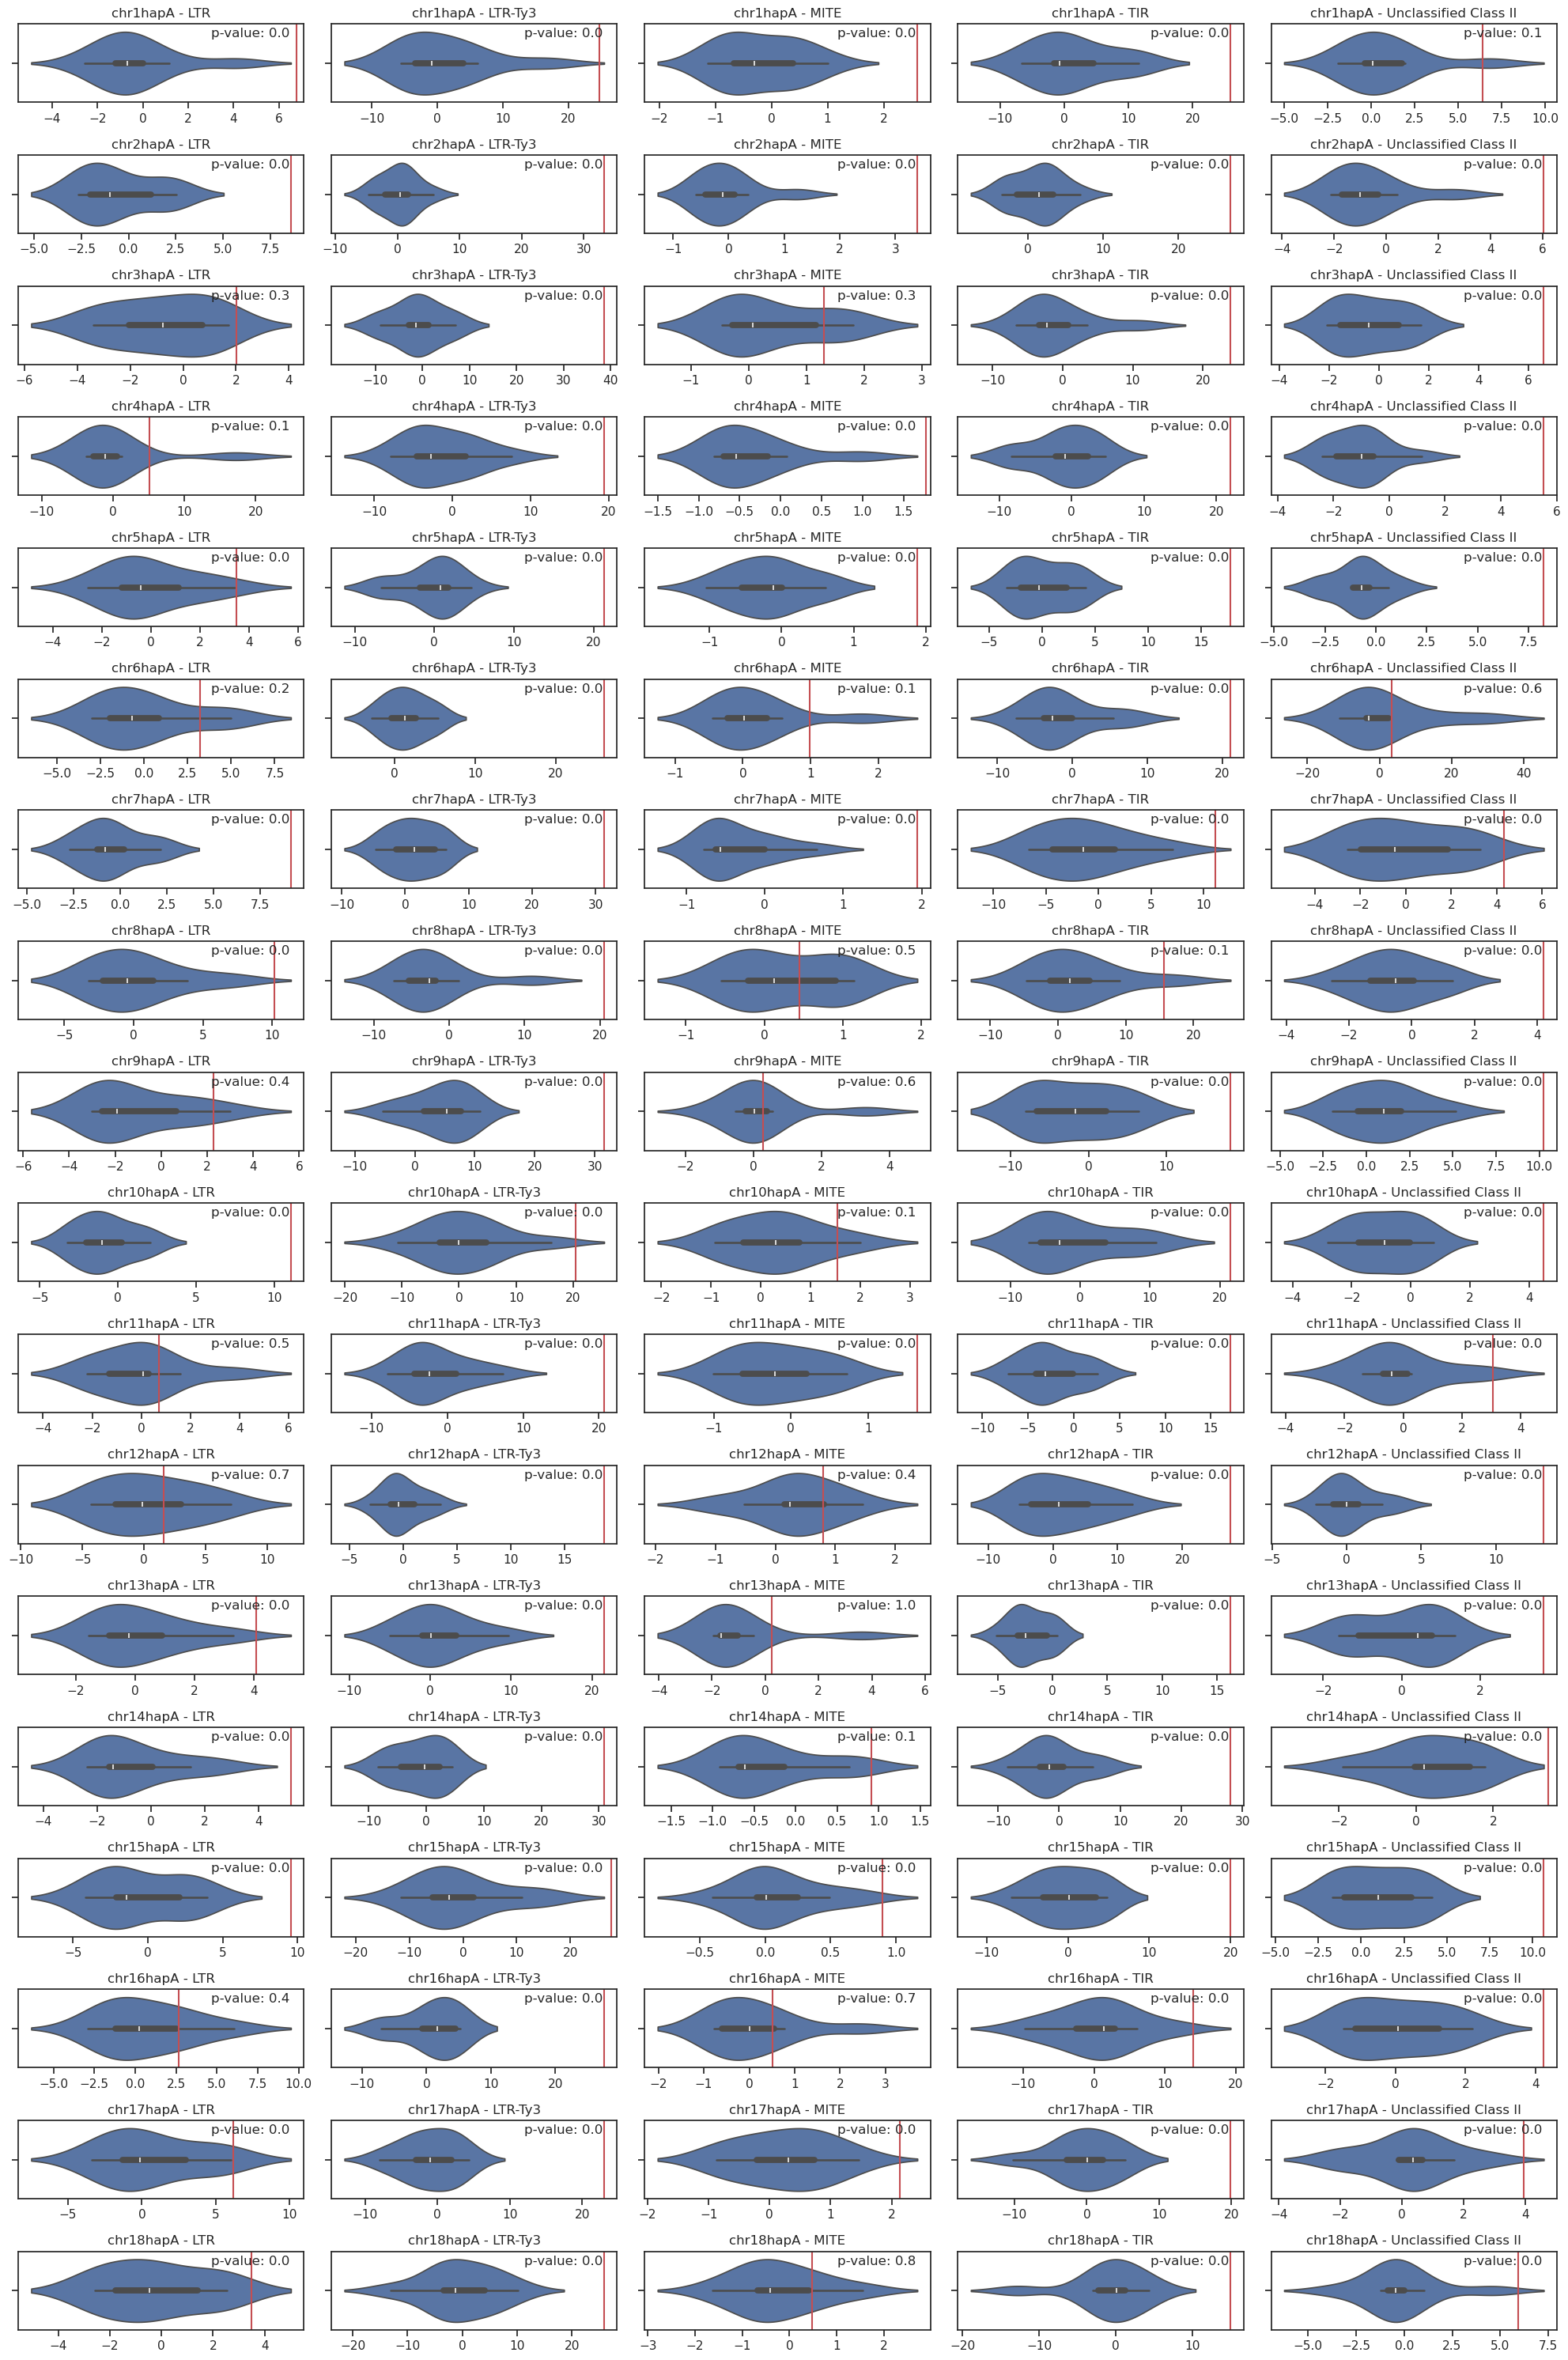

In [781]:
# #all_TE_orders = ["DIRS", "Helitron", "LARD", "LINE", "LTR", "LTR-Ty3", "MITE", "Maverick", \
# #                "SINE", "TIR", "TRIM", "Unclassified Class", "Unclassified Class I", "Unclassified Class II"]
# interested_TE_orders = ["LTR", "LTR-Ty3", "MITE", "TIR", "Unclassified Class II"]
# chr_count = 18
# fig, axs = plt.subplots(chr_count, len(interested_TE_orders), figsize=(20,30))
# for n in range(1, chr_count+1):
#     for i, te in enumerate(interested_TE_orders):
#         ax = axs[n-1,i]
#         te_perm_vals, te_obs_val, te_pval = get_covdiff_p_value(perm_results, observed_result, f"chr{n}A", te)
#         sns.violinplot(te_perm_vals, ax=ax, orient="h")
#         ax.set_title(f'chr{n}{hap} - {te}')
#         ax.axvline(te_obs_val, color='r')
#         ax.text(0.95, 0.95, f'p-value: {te_pval}', ha='right', va='top', transform=ax.transAxes)

# plt.tight_layout()
# plt.show()

### compute pvalues for the observed using null distribution generated from permutations

first generate a covdiff summary table that has chr, TE order, observed coverage difference, p value and the FDR-corrected p value.

In [246]:
len(perm_results)

5000

In [20]:
#first generate a table with chromosome as rows, TEs as columns, observed covdiff as values
# all_TE_orders = ["DIRS", "Helitron", "LARD", "LINE", "LTR", "LTR-Ty3", "MITE", "Maverick", \
#                 "SINE", "TIR", "TRIM", "Unclassified Class", "Unclassified Class I", "Unclassified Class II"]
interested_TE_cat = TE_post_analysis_df["COS"].unique()

chr_count = 18
summary_cols = ["chr", "TEtype", "obs_covdiff", "pval"]
covdiff_summary_data = []
counter = 1
for n in range(1,chr_count+1):
    for hap in ["A", "B"]:
        for te in interested_TE_cat:
            chrom = "chr"+str(n)+hap
            row = [] 
            te_perm_vals, te_obs_val, te_pval = get_covdiff_p_value(perm_results, observed_result, f"chr{n}{hap}", te)#, use_transformed=True)
            row = {"chr":chrom, "TEtype":te, "obs_covdiff":te_obs_val, "pval":te_pval}
            covdiff_summary_data.append(row)
covdiff_summary_data = pd.DataFrame(covdiff_summary_data, columns=summary_cols)
covdiff_summary_data.to_csv("covdiff_summary_data_superfam.tsv", sep="\t")
covdiff_summary_data

,chr,TEtype,obs_covdiff,pval
0,chr1A,noCat,4.898384,0.0726
1,chr1A,ClassII:TIR:?,7.763364,0.0032
2,chr1A,ClassI:LTR:Copia,4.295907,0.0272
3,chr1A,ClassII:TIR:Tc1,-1.355232,0.1074
4,chr1A,ClassII:TIR:MuDR,6.494199,0.0126
...,...,...,...,...
895,chr18B,ClassII:Helitron:Helitron,-0.097631,0.9226
896,chr18B,ClassI:LARD:?,-0.247384,0.8522
897,chr18B,ClassI:?:?,-0.062008,0.9986
898,chr18B,ClassII:TIR:CACTA,1.261238,0.0092


### now convert it into a heatmap

chromosomes as rows, TE orders as columns

observed difference as hue, significance as astericks

In [191]:
#covdiff_summary_data = pd.read_csv("covdiff_summary_data.tsv", sep="\t", usecols=(1,2,3,4))
#rejected, pval_FDRcorrected = fdrcorrection(np.array(covdiff_summary_data["pval"]),alpha=0.05)
#covdiff_summary_data["pval_FDRcorr"] = pval_FDRcorrected
#covdiff_summary_data.to_csv("covdiff_summary_data_superfam.tsv", sep="\t", index=False, header=True)
covdiff_summary_data = pd.read_csv("covdiff_summary_data_superfam.tsv",sep="\t")
covdiff_summary_data

,chr,TEtype,obs_covdiff,pval,pval_FDRcorr
0,chr1A,noCat,4.898384,0.0726,0.409390
1,chr1A,ClassII:TIR:?,7.763364,0.0032,0.053333
2,chr1A,ClassI:LTR:Copia,4.295907,0.0272,0.224182
3,chr1A,ClassII:TIR:Tc1,-1.355232,0.1074,0.479704
4,chr1A,ClassII:TIR:MuDR,6.494199,0.0126,0.124615
...,...,...,...,...,...
895,chr18B,ClassII:Helitron:Helitron,-0.097631,0.9226,1.000000
896,chr18B,ClassI:LARD:?,-0.247384,0.8522,1.000000
897,chr18B,ClassI:?:?,-0.062008,0.9986,1.000000
898,chr18B,ClassII:TIR:CACTA,1.261238,0.0092,0.098571


In [192]:
print(selected_TEs)

['ClassI:LTR:Copia', 'ClassI:LTR:Gypsy', 'ClassII:?:?', 'ClassII:Helitron:?', 'ClassII:MITE:?', 'ClassII:TIR:?', 'ClassII:TIR:MuDR', 'ClassII:TIR:PIF', 'ClassII:TIR:Tc1', 'ClassII:TIR:hAT', 'noCat']


In [267]:
# can opt to filter to retain favourite TEs here to visualise!
# since some TE orders had 0.05% coverage (look at TE_post_analysis_df_sum above) can choose to skip them.
selected_TEs = TE_post_analysis_df_superfam_sum[TE_post_analysis_df_superfam_sum["coverage_perc"]>=0.5].index.tolist()
covdiff_summary_data_tmp = covdiff_summary_data[covdiff_summary_data["TEtype"].isin(selected_TEs)]
covdiff_summary_pivot_obs_covdiff = sort_pivot_rows_by_natural_chr(covdiff_summary_data_tmp.pivot(index="chr", columns="TEtype", values="obs_covdiff"))#[TE_order_dict["All"]]
covdiff_summary_pivot_pval = covdiff_summary_data_tmp.pivot(index="chr", columns="TEtype", values="pval_FDRcorr")#[TE_order_dict["All"]]
# convert pval into astericks for categorising significance level
covdiff_summary_pivot_pval = sort_pivot_rows_by_natural_chr(covdiff_summary_pivot_pval.applymap(replace_pvalues_as_asterick))
covdiff_summary_pivot_pval.columns == covdiff_summary_pivot_obs_covdiff.columns

/tmp/ipykernel_383573/4193414436.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  covdiff_summary_pivot_pval = sort_pivot_rows_by_natural_chr(covdiff_summary_pivot_pval.applymap(replace_pvalues_as_asterick))


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [268]:
covdiff_summary_pivot_obs_covdiff = covdiff_summary_pivot_obs_covdiff.reset_index()
covdiff_summary_pivot_obs_covdiff["chr"] = covdiff_summary_pivot_obs_covdiff["chr"].str.replace("chr", "Cen")
covdiff_summary_pivot_obs_covdiff = covdiff_summary_pivot_obs_covdiff.set_index("chr")
covdiff_summary_pivot_pval = covdiff_summary_pivot_pval.reset_index()
covdiff_summary_pivot_pval["chr"] = covdiff_summary_pivot_pval["chr"].str.replace("chr", "Cen")
covdiff_summary_pivot_pval = covdiff_summary_pivot_pval.set_index("chr")
covdiff_summary_pivot_obs_covdiff

TEtype,ClassI:LTR:Copia,ClassI:LTR:Gypsy,ClassII:?:?,ClassII:Helitron:?,ClassII:MITE:?,ClassII:TIR:?,ClassII:TIR:MuDR,ClassII:TIR:PIF,ClassII:TIR:Tc1,ClassII:TIR:hAT,noCat
chr,,,,,,,,,,,
Cen1A,4.295907,13.648325,2.728961,-0.390450,1.069760,7.763364,6.494199,-1.691664,-1.355232,1.590364,4.898384
Cen1B,2.447251,18.318780,0.482414,-0.735624,-0.017668,8.291575,6.002138,-1.249289,-1.295371,0.115358,-0.581604
Cen2A,6.447335,24.920569,2.812173,-0.538742,2.044245,3.295059,9.137271,1.112635,-0.944808,2.360878,1.558834
Cen2B,7.133790,14.216127,-0.804511,-0.676528,-1.165126,0.416084,-0.772108,0.410302,-0.796161,0.038540,5.383459
Cen3A,-1.140701,24.951464,1.915257,0.843648,-0.281237,5.888702,2.869583,-1.232305,-1.640334,6.679694,-3.021230
Cen3B,0.289595,18.153590,-1.876843,1.372210,-0.280914,0.748921,3.480452,-1.359154,-1.799766,3.659147,4.593084
Cen4A,1.858360,7.950938,1.687382,-0.478775,0.450791,1.094971,7.864352,-0.252328,0.809980,0.071759,0.936963
Cen4B,4.371058,19.232603,-0.174932,2.038205,0.233314,2.340368,12.059256,-0.442175,0.482763,4.836247,4.622414
Cen5A,0.890912,10.754190,4.601654,-1.073196,0.350690,3.697668,2.694425,-0.430228,-0.449536,1.045450,7.964100


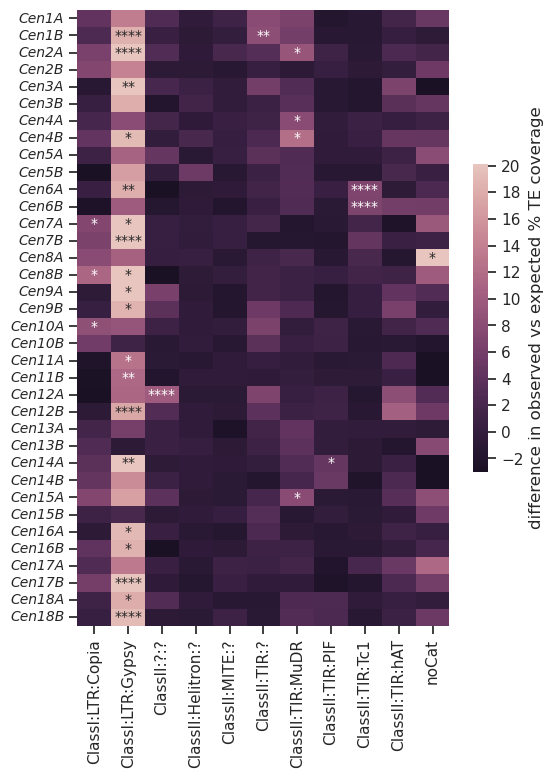

In [270]:
plt.figure(figsize=(6, 8))
ax = sns.heatmap(covdiff_summary_pivot_obs_covdiff, annot=covdiff_summary_pivot_pval, fmt="", \
                 robust=True, cbar_kws={"shrink": 0.5, "label": "difference in observed vs expected % TE coverage", "ticks": range(-10, 21, 2)}, \
                 annot_kws={"fontsize": 10}, cmap=sns.cubehelix_palette(as_cmap=True, reverse=True, gamma=1.3))
ax.set(ylabel="", xlabel="")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
labels = ax.get_yticklabels()
for lbl in labels:
    lbl.set_style('italic')
plt.show()

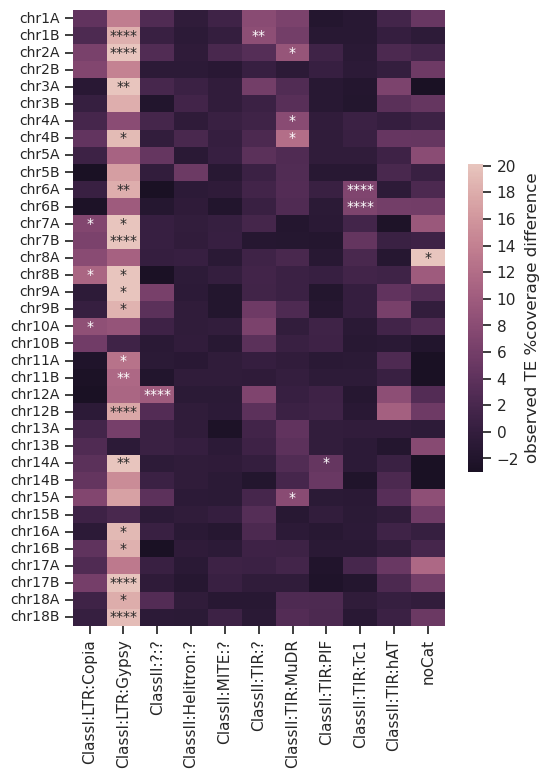

In [30]:
plt.figure(figsize=(6, 8))
ax = sns.heatmap(covdiff_summary_pivot_obs_covdiff, annot=covdiff_summary_pivot_pval, fmt="", \
                 robust=True, cbar_kws={"shrink": 0.5, "label": "observed TE %coverage difference", "ticks": range(-10, 21, 2)}, \
                 annot_kws={"fontsize": 10}, cmap=sns.cubehelix_palette(as_cmap=True, reverse=True, gamma=1.3))
ax.set(ylabel="", xlabel="")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

plt.show()

In [228]:
observed_result

,chr,TEtype,coverage_centromere,coverage_noncentromere,coverage_diff
474,chr1A,noCat,15.261003,10.362618,4.898384
473,chr1A,ClassII:TIR:hAT,6.865959,5.518047,1.347913
472,chr1A,ClassII:TIR:Tc1-Mariner,0.000000,0.192481,-0.192481
471,chr1A,ClassII:TIR:Tc1,0.156080,1.511313,-1.355232
470,chr1A,ClassII:TIR:PIF-Harbinger,0.063437,0.036029,0.027408
...,...,...,...,...,...
428,chr18B,ClassI:LINE:?,0.000000,0.526070,-0.526070
427,chr18B,ClassI:LARD:?,0.711661,0.959045,-0.247384
426,chr18B,ClassI:DIRS:DIRS,0.000000,0.007116,-0.007116
448,chr18B,ClassII:TIR:hAT,6.380048,4.096573,2.283475


In [235]:
observed_result_sum

,chr,region,coverage
0,chr1A,coverage_centromere,90.821729
1,chr1A,coverage_noncentromere,49.348437
2,chr1B,coverage_centromere,84.280482
3,chr1B,coverage_noncentromere,44.869650
4,chr2A,coverage_centromere,96.903188
...,...,...,...
67,chr17B,coverage_noncentromere,54.313518
68,chr18A,coverage_centromere,70.854478
69,chr18A,coverage_noncentromere,46.627647
70,chr18B,coverage_centromere,77.148537


In [234]:
observed_result_sum.to_csv("repeat_cov_centromere_noncentromere.tsv",sep="\t",index=None)

/tmp/ipykernel_383573/1276626094.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  observed_result_sum = pd.melt(observed_result, id_vars=["chr", "TEtype"], value_vars=["coverage_centromere", "coverage_noncentromere"], var_name="region", value_name="coverage").groupby(["chr", "region"])["coverage"].sum().reset_index()
/tmp/ipykernel_383573/1276626094.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["centromere","non-centromere"], fontsize=11)


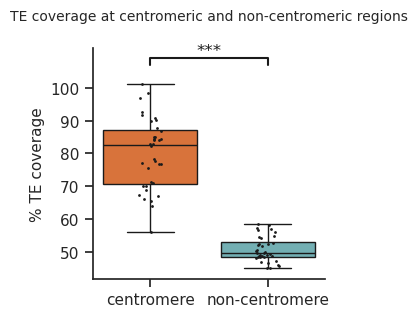

In [254]:
sns.set_style("ticks")
observed_result_sum = pd.melt(observed_result, id_vars=["chr", "TEtype"], value_vars=["coverage_centromere", "coverage_noncentromere"], var_name="region", value_name="coverage").groupby(["chr", "region"])["coverage"].sum().reset_index()
fig, ax = plt.subplots(figsize=(3,3))

sns.boxplot(data=observed_result_sum, x="region", y="coverage", hue="region", palette=["#f26b21", "#68b8be"], ax=ax, linewidth=1, linecolor="k")
sns.stripplot(data=observed_result_sum, x="region", y="coverage", color="k", size=2, ax=ax)

ax.set(ylabel="", xlabel="")
ax.set_ylabel("% TE coverage",fontsize=11)
ax.set_xticklabels(["centromere","non-centromere"], fontsize=11)
ax.set_title("TE coverage at centromeric and non-centromeric regions", fontsize=10, pad=20)
plt.yticks(list(range(101))[::10])
sns.despine(ax=ax, trim=False, left=False, bottom=False)
x1,x2 = 0,1
y,h,col = observed_result_sum["coverage"].max() + 6,2,"k"
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
plt.show()

In [197]:
observed_result_sum

NameError: name 'observed_result_sum' is not defined

is there a significant difference between centromere and non-centromere TE coverage?

In [237]:
centromere_cov_vals = np.array(observed_result_sum[observed_result_sum["region"] == "coverage_centromere"]["coverage"])
noncentromere_cov_vals = np.array(observed_result_sum[observed_result_sum["region"] == "coverage_noncentromere"]["coverage"])
tstat, pvalue = stats.ttest_ind(centromere_cov_vals, noncentromere_cov_vals)
print(f"t-statistic: {tstat}, pvalue: {pvalue}")
if pvalue < 0.05:
    print("pvalue < 0.05, reject null.")

t-statistic: 15.409199859049435, pvalue: 3.458039309110793e-24
pvalue < 0.05, reject null.


### Centromere size differences between haplotypes

In [238]:
centromere_df = pd.read_excel(centromere_file, engine="openpyxl", usecols=(0,1,2,3,5))
cenhap = []
cenchrname = []
for index, row in centromere_df.iterrows():
    cenhap.append(row["chr"][-1])
    cenchrname.append(row["chr"][:-1])
centromere_df["hap"] = cenhap
centromere_df["chr_name"] = cenchrname
centromere_df["size"] = centromere_df["size"]/1000
centromere_df_ratio = centromere_df.copy()

def calculate_centromere_size_ratio(group):
    hapA_size = group.loc[group["hap"]=="A", "size"].iloc[0]
    hapB_size = group.loc[group["hap"]=="B", "size"].iloc[0]
    group["size_ratio"] = round(hapA_size/hapB_size,2)
    return group
centromere_df_ratio = centromere_df_ratio.groupby("chr_name").apply(calculate_centromere_size_ratio)
centromere_df_ratio

chr    start      end     size centromere hap chr_name  \
chr_name                                                                 
chr1     0    chr1A  1718008  2036434  318.426      cen1A   A     chr1   
         1    chr1B  1679641  2024448  344.807      cen1B   B     chr1   
chr10    18  chr10A   774638  1010882  236.244     cen10A   A    chr10   
         19  chr10B   744572  1100491  355.919     cen10B   B    chr10   
chr11    20  chr11A   657124  1194917  537.793     cen11A   A    chr11   
         21  chr11B   639299  1173308  534.009     cen11B   B    chr11   
chr12    22  chr12A  1074208  1319319  245.111     cen12A   A    chr12   
         23  chr12B  1347210  1612234  265.024     cen12B   B    chr12   
chr13    24  chr13A   867063  1192301  325.238     cen13A   A    chr13   
         25  chr13B   807093  1138885  331.792     cen13B   B    chr13   
chr14    26  chr14A  1156088  1498910  342.822     cen14A   A    chr14   
         27  chr14B  1094012  1431560  337.548     cen14B   B    chr14   
chr15    28  chr15A   532365   899633  367.268     cen15A   A    chr15   
         29  chr15B   514405   781823  267.418     cen15B   B    chr15   
chr16    30  chr16A   708040  1002809  294.769     cen16A   A    chr16   
         31  chr16B   684648   964992  280.344     cen16B   B    chr16   
chr17    32  chr17A   520321   878821  358.500     cen17A   A    chr17   
         33  chr17B   459378   751483  292.105     cen17B   B    chr17   
chr18    34  chr18A  1158322  1413905  255.583     cen18A   A    chr18   
         35  chr18B  1188276  1437271  248.995     cen18A   B    chr18   
chr2     2    chr2A  2244207  2552847  308.640      cen2A   A     chr2   
         3    chr2B  2222043  2477982  255.939      cen2B   B     chr2   
chr3     4    chr3A  1593991  1877227  283.236      cen3A   A     chr3   
         5    chr3B  1462361  1757066  294.705      cen3B   B     chr3   
chr4     6    chr4A  1373985  1661688  287.703      cen4A   A     chr4   
         7    chr4B  1360511  1637020  276.509      cen4B   B     chr4   
chr5     8    chr5A  1963325  2399107  435.782      cen5A   A     chr5   
         9    chr5B  1989904  2199877  209.973      cen5B   B     chr5   
chr6     10   chr6A  2325076  2627632  302.556      cen6A   A     chr6   
         11   chr6B  2253115  2569015  315.900      cen6B   B     chr6   
chr7     12   chr7A  1434065  1713521  279.456      cen7A   A     chr7   
         13   chr7B  1458955  1700142  241.187      cen7B   B     chr7   
chr8     14   chr8A  1055478  1294381  238.903      cen8A   A     chr8   
         15   chr8B  1167967  1377956  209.989      cen8B   B     chr8   
chr9     16   chr9A  1150503  1367818  217.315      cen9A   A     chr9   
         17   chr9B  1231733  1482851  251.118      cen9B   B     chr9   

             size_ratio  
chr_name                 
chr1     0         0.92  
         1         0.92  
chr10    18        0.66  
         19        0.66  
chr11    20        1.01  
         21        1.01  
chr12    22        0.92  
         23        0.92  
chr13    24        0.98  
         25        0.98  
chr14    26        1.02  
         27        1.02  
chr15    28        1.37  
         29        1.37  
chr16    30        1.05  
         31        1.05  
chr17    32        1.23  
         33        1.23  
chr18    34        1.03  
         35        1.03  
chr2     2         1.21  
         3         1.21  
chr3     4         0.96  
         5         0.96  
chr4     6         1.04  
         7         1.04  
chr5     8         2.08  
         9         2.08  
chr6     10        0.96  
         11        0.96  
chr7     12        1.16  
         13        1.16  
chr8     14        1.14  
         15        1.14  
chr9     16        0.87  
         17        0.87

In [242]:
centromere_df_ratio[centromere_df_ratio["hap"]=="A"]["size_ratio"].median()

1.025

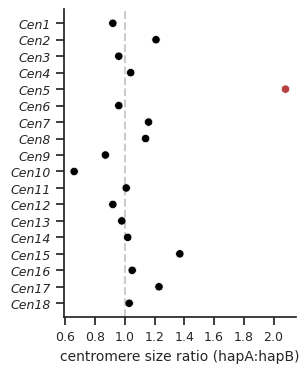

In [253]:
centromere_df_ratio_tmp = centromere_df_ratio.copy()
cen_name = ["Cen"+n.split("chr")[-1] for n in centromere_df_ratio_tmp["chr_name"].tolist()]
centromere_df_ratio_tmp["cen_name"] = cen_name
desired_order = ["Cen"+str(n) for n in range(1,19)]
plt.figure(figsize=(3,4))
centromere_df_ratio_tmp = centromere_df_ratio_tmp.drop_duplicates(subset=["cen_name"]).reset_index(drop=True)
centromere_df_ratio_tmp = centromere_df_ratio_tmp.set_index("cen_name").loc[desired_order].reset_index()
centromere_df_ratio_tmp['highlight'] = 'n'
centromere_df_ratio_tmp.loc[centromere_df_ratio_tmp['size_ratio'] > 1.4, 'highlight'] = 'y'
centromere_df_ratio_tmp.loc[centromere_df_ratio_tmp['size_ratio'] < 0.4, 'highlight'] = 'y'
plt.axvline(x=1, color='black', linestyle='--', alpha=0.2)  # Vertical line at x=1
ax = sns.scatterplot(data=centromere_df_ratio_tmp, x="size_ratio", y="cen_name",\
                     hue='highlight', palette=["black","#B64140"], legend=False)
plt.xlabel('centromere size ratio (hapA:hapB)', fontsize=10)
plt.xticks(fontsize=9)
plt.ylabel('')
plt.yticks(fontsize=9)
sns.despine(ax=ax, trim=False, left=False, bottom=False)
plt.gca().xaxis.set_major_locator(MultipleLocator(0.2))
labels = ax.get_yticklabels()
for lbl in labels:
    lbl.set_style('italic')
# plt.yticks(range(len(df)), df['chr'])  # Set y-axis ticks as chromosome names
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.show()

/tmp/ipykernel_387906/4293800335.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)


[None]

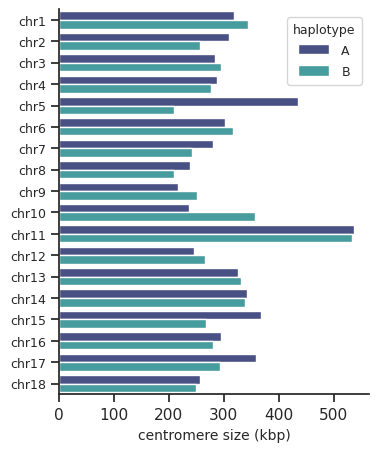

In [111]:
plt.figure(figsize=(4,5))
ax = sns.barplot(centromere_df, x="size", y="chr_name", hue="hap", palette="mako")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
ax.set_xlabel("centromere size (kbp)",fontsize=10)
ax.set_ylabel("")
sns.despine(ax=ax, trim=False, left=False, bottom=False)
plt.legend(title="haplotype")
plt.setp(ax.get_legend().get_texts(), fontsize='9')
plt.setp(ax.get_legend().get_title(), fontsize='9')

### young TE enrichment
For each identified refTE there's an average percentage identity for all the matched TEs identified in the genome.

In [73]:
TE_post_analysis_df

,TE,length,covg,frags,fullLgthFrags,copies,fullLgthCopies,meanId,sdId,minId,...,q25LgthPerc,medLgthPerc,q75LgthPerc,maxLgthPerc,COS,TE_age,TE_age_Mya,Class,Order,Superfamily
0,hapA-B-G1016-Map6_reversed,1571.0,25406.0,56.0,11.0,53.0,12.0,85.84,8.44,71.3,...,9.48,12.67,25.97,101.4,noCat,70800000.0,70.8,noCat,Unclassified Class,noCat
1,hapA-B-G1023-Map3,1598.0,30086.0,68.0,7.0,62.0,8.0,80.87,8.27,64.1,...,11.33,18.18,27.66,102.94,ClassII:TIR:?,95650000.0,95.65,ClassII,TIR,?
2,hapA-B-G1024-Map3,1597.0,19086.0,58.0,4.0,53.0,5.0,80.94,9.5,65.3,...,7.51,16.59,18.6,105.39,ClassI:LTR:Copia,95300000.0,95.3,ClassI,LTR,Copia
3,hapA-B-G1025-Map10_reversed,1980.0,2338.0,8.0,1.0,7.0,1.0,87.43,7.28,72.7,...,2.42,3.74,10.35,95.25,ClassII:TIR:Tc1,62850000.0,62.85,ClassII,TIR,Tc1
4,hapA-B-G1026-Map3,1629.0,10873.0,36.0,3.0,33.0,3.0,84.68,8.0,72.2,...,4.11,9.45,19.89,100.12,noCat,76600000.0,76.6,noCat,Unclassified Class,noCat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,hapB-B-R99-Map3,829.0,17290.0,100.0,2.0,86.0,2.0,84.63,6.6,68.5,...,7.12,12.67,35.22,100.0,ClassII:MITE:?,76850000.0,76.85,ClassII,MITE,?
2882,hapB-B-R991-Map4,1518.0,22144.0,58.0,6.0,52.0,6.0,78.72,9.63,63.0,...,6.92,12.78,37.15,103.23,noCat,106400000.0,106.4,noCat,Unclassified Class,noCat
2883,hapB-B-R995-Map3,610.0,5800.0,16.0,6.0,13.0,7.0,87.26,5.92,79.55,...,27.54,99.84,100.82,105.74,ClassI:LTR:Gypsy,63700000.0,63.7,ClassI,LTR-Ty3,Gypsy
2884,hapB-B-R996-Map3,683.0,1366.0,2.0,2.0,2.0,2.0,97.05,4.17,94.1,...,100.0,100.0,100.0,100.0,noCat,14750000.0,14.75,noCat,Unclassified Class,noCat


In [ ]:
TE_post_analysis_df["